# BRI Score: Credit Scoring Model

## Import Library

In [345]:
import warnings
import string
import random
warnings.filterwarnings('ignore')

import math
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from scipy import stats
from scipy.stats import uniform, randint

from skorecard.bucketers import DecisionTreeBucketer, OptimalBucketer, EqualFrequencyBucketer, EqualWidthBucketer, AgglomerativeClusteringBucketer
from skorecard.preprocessing import WoeEncoder
from skorecard.pipeline import BucketingProcess
from sklearn.pipeline import make_pipeline
from skorecard.pipeline.pipeline import SkorecardPipeline, to_skorecard_pipeline
from skorecard import Skorecard
from skorecard.rescale import ScoreCardPoints
from skorecard.bucketers import UserInputBucketer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, roc_curve, roc_auc_score, auc, log_loss, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from itertools import combinations
import shap
import time
import re
import pickle
import joblib
from openpyxl import load_workbook

import os
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sqlalchemy import create_engine

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 600)

## Functions

In [442]:
def get_score(PD, A, B):
    score = A + B * np.log(PD / (1 - PD))
    return score

def get_credit_score(calibrated_score, min_score=0, max_score=1000, A=-135.8, B=-246.6):
    return max(min(round(A + B * np.log(calibrated_score / (1 - calibrated_score))), max_score), min_score)
    
def vif_coef(x_train_woe, feat_list, model, iv_ref):

    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = feat_list

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(x_train_woe[feat_list].fillna(0).values, i)
                              for i in range(len(feat_list))]

    df_ = pd.DataFrame(list(zip(feat_list, model.coef_[0])), columns=['feature', 'coefficient'])

    df_vif_coef = vif_data\
        .merge(df_, on='feature', how='inner')\
        .merge(iv_ref, on='feature', how='inner')
    df_vif_coef['Abs Coefficient'] = df_vif_coef['coefficient'].abs()
    df_vif_coef = df_vif_coef.rename(columns={'feature': 'Features', 'coefficient': 'Coefficient'})[['Features', 'VIF', 'Coefficient', 'Abs Coefficient', 'IV']]
    
    return df_vif_coef

def props_good_bad(data, bad_flag, grouped_by):
    _ = data.groupby(grouped_by).size().reset_index().rename(columns={0: 'count'})
    zero = data[data[bad_flag] == 0].groupby(grouped_by).size().reset_index().rename(columns={0: 'co_good'})['co_good']
    one = data[data[bad_flag] == 1].groupby(grouped_by).size().reset_index().rename(columns={0: 'co_bad'})['co_bad']
    result = pd.concat([_, zero, one], axis=1)
    result['props_good'] = result['co_good'] / result['count']
    result['props_bad'] = result['co_bad'] / result['count']
    
    return result

def train_test_prop(train, test):
    tr_s = train.shape[0]
    te_s = test.shape[0]
    total = tr_s + te_s
    
    tr_p = str(round((tr_s / total) * 100)) + '%'
    te_p = str(round((te_s / total) * 100)) + '%'
    
    return f'{tr_p} : {te_p}'

def train_test_info(train, test, flag):
    print(f'Train shape: {train.shape}; Test shape: {test.shape}')
    print(train_test_prop(train, test))
    print()
    print('Train Flag Proportion:')
    print(train[flag].value_counts())
    print(train[flag].value_counts(normalize=True))
    print()
    print('Test Flag Proportion:')
    print(test[flag].value_counts())
    print(test[flag].value_counts(normalize=True))

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def calculate_gini(df, flag, name='train'):
    fpr, tpr, thresholds = roc_curve(df[flag], df['predict_proba'])
    roc_auc = auc(fpr, tpr)
    
    return 'Gini ' + name + ' = ' + str(round(2 * roc_auc - 1, 2))

def calc_gini(df, flag):
    fpr, tpr, thresholds = roc_curve(df[flag], df['predict_proba'])
    roc_auc = auc(fpr, tpr)
    
    return round(2 * roc_auc - 1, 2)

def print_gini(train, test, flag):
    print(calculate_gini(train, flag, 'train'))
    print(calculate_gini(test, flag, 'test'))
    
def plot_roc_curve(fpr, tpr, auc_score):
    gini_index = (2*auc_score)-1
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='navy', lw=lw, label='AUC Score = %0.3f\nGini Index = %0.3f' % (auc_score, gini_index))
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Model A-Score')
    plt.legend(loc="lower right")
    
    plt.show()
    return

def draw_auc(df, flag):
    fpr, tpr, thresholds = roc_curve(df[flag], df['predict_proba'])
    roc_auc = metrics.auc(fpr, tpr)
    # Draw Chart
    plot_title = get_df_name(df)
    plt.title('Receiver Operating Characteristic (%s)' %plot_title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def summary_auc(flag, train, test, val=None):
    draw_auc(train, flag)
    
    if val != None:
        draw_auc(val, flag)
        
    draw_auc(test, flag)
    
def final_bin(df, flag):

#     percentile = pd.DataFrame(df['cifno'])
    percentile = pd.DataFrame()
    percentile['probability'] = df['predict_proba']
    percentile['actual_flag_1'] = df[flag]
    percentile.sort_values(by=['probability'], ascending=False, inplace=True)
    
    percentile.reset_index(inplace=True)
    del percentile['index']
    percentile.reset_index(inplace=True)
    percentile['decile'] = pd.cut(percentile['index'], 10, labels=False, duplicates='drop')+1
    
    percentile.sort_values(by=['probability'], inplace=True, ascending=False)
    
    percentile[['decile', 'probability']].groupby(['decile']).max().sort_values(by=['decile'], ascending=True)
    del percentile['index']
    
    percentile['bins'] = pd.qcut(percentile['probability'], 10, duplicates = 'drop') # 10 -> 100
    
    return percentile.groupby('bins').agg({'actual_flag_1': [len, 'mean', 'sum'], 'probability': 'mean'})

def decile(df, flag, pred='predict_proba', bin=10, ascending=True):
#     percentile = pd.DataFrame(test['cifno'])
    percentile = pd.DataFrame()
    percentile['probability'] = df[pred] #
    percentile['actual_flag_1'] = df[flag]
    percentile.sort_values(by=['probability'], ascending=False, inplace=True)
    
    percentile.reset_index(inplace=True)
    del percentile['index']
    percentile.reset_index(inplace=True)
    percentile['decile'] = pd.cut(percentile['index'], bin, labels=False, duplicates='drop')+1
    
    percentile.sort_values(by=['probability'], inplace=True, ascending=False)
    
    # percentile[['decile', 'probability']].groupby(['decile']).max().sort_values(by=['decile'], ascending=True)
    del percentile['index']
    
    tes0 = pd.crosstab(percentile['decile'], percentile['actual_flag_1'])
    tes = pd.crosstab(percentile['decile'], percentile['actual_flag_1'], normalize='index')
    tes2 = percentile.groupby(['decile'])[['probability']].min()
    tes3 = percentile.groupby(['decile'])[['probability']].max()
    
    temp_df = pd.DataFrame(tes[0])
    temp_df['1'] = tes[1]
    temp_df['actual_flag_0'] = tes0[0]
    temp_df['actual_flag_1'] = tes0[1]
    temp_df['min_range'] = tes2
    temp_df['max_range'] = tes3
    
    temp_df = temp_df.rename(columns={0:'flag_0', '1':'flag_1'})
    
    temp_df['population'] = temp_df['actual_flag_0'] + temp_df['actual_flag_1']
    temp_df['mean'] = temp_df['actual_flag_1'] / percentile['actual_flag_1'].sum()
    
    temp_df = temp_df[['min_range', 'max_range', 'flag_0', 'flag_1', 'population', 'actual_flag_0', 'actual_flag_1', 'mean']]

    def calculate_cumulative_bad_rate(row):
        
        cumulative_actual_flag_1 = temp_df.loc[:row.name, 'actual_flag_1'].sum()
        cumulative_population = temp_df.loc[:row.name, 'population'].sum()
        
        return cumulative_actual_flag_1 / cumulative_population
    
    if ascending == False:
        temp_df = temp_df.reset_index().sort_values('decile', ascending=False).drop('decile', axis=1)
        temp_df.insert(0, 'decile', [i+1 for i in range(bin)])
        temp_df = temp_df.set_index('decile')

        temp_df['cum_flag_1_rate'] = temp_df.apply(calculate_cumulative_bad_rate, axis=1)
        
        return temp_df

    temp_df['cum_flag_1_rate'] = temp_df.apply(calculate_cumulative_bad_rate, axis=1)
        
    return temp_df

def calculate_gini_per_type(df, flag):
    fpr, tpr, thresholds = roc_curve(df[flag], df['predict_proba'])
    roc_auc = auc(fpr, tpr)
    
    return str(round(2 * roc_auc - 1, 2))

def print_gini_per_type(train, test, flag):
    print(f'Gini train = {calculate_gini_per_type(train, flag)}')
    print(f'Gini test = {calculate_gini_per_type(test, flag)}')
    
def draw_auc_per_type(df, flag, name):
    fpr, tpr, thresholds = roc_curve(df[flag], df['predict_proba'])
    roc_auc = metrics.auc(fpr, tpr)
    # Draw Chart
    plot_title = name
    plt.title('Receiver Operating Characteristic (%s)' %plot_title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def summary_auc_per_type(flag, train, test, val=None):
    draw_auc_per_type(train, flag, 'train')
    
    if val != None:
        draw_auc_per_type(val, flag, 'val')
        
    draw_auc_per_type(test, flag, 'test')

def gini_per_porto(df):
    
    all = df.copy()

    # all trx
    sep = all.groupby(['loan_type']).agg({'flag_bad':[len, 'sum', 'mean']}).reset_index()
    sep.columns = sep.columns.droplevel()
    sep.columns = ['porto', 'count', 'co_bad', 'bad_rate']
    sep['gini'] = np.nan
    sep.loc[0, 'gini'] = calc_gini(all[all['loan_type'] == 'CC'], flag)
    sep.loc[1, 'gini'] = calc_gini(all[all['loan_type'] == 'CERIA'], flag)
    sep['trx_type'] = 'All'

    # 1st trx
    sep_1st = all[all['trx_at_acc'] == 1].groupby(['loan_type']).agg({'flag_bad':[len, 'sum', 'mean']}).reset_index()
    sep_1st.columns = sep_1st.columns.droplevel()
    sep_1st.columns = ['porto', 'count', 'co_bad', 'bad_rate']
    sep_1st['gini'] = np.nan
    sep_1st.loc[0, 'gini'] = calc_gini(all[(all['loan_type'] == 'CC') & (all['trx_at_acc'] == 1)], flag)
    sep_1st.loc[1, 'gini'] = calc_gini(all[(all['loan_type'] == 'CERIA') & (all['trx_at_acc'] == 1)], flag)
    sep_1st['trx_type'] = '1st Trx'

    # >1st trx
    sep_non1st = all[all['trx_at_acc'] == 1].groupby(['loan_type']).agg({'flag_bad':[len, 'sum', 'mean']}).reset_index()
    sep_non1st.columns = sep_non1st.columns.droplevel()
    sep_non1st.columns = ['porto', 'count', 'co_bad', 'bad_rate']
    sep_non1st['gini'] = np.nan
    sep_non1st.loc[0, 'gini'] = calc_gini(all[(all['loan_type'] == 'CC') & (all['trx_at_acc'] > 1)], flag)
    sep_non1st.loc[1, 'gini'] = calc_gini(all[(all['loan_type'] == 'CERIA') & (all['trx_at_acc'] > 1)], flag)
    sep_non1st['trx_type'] = '> 1st Trx'

    # Comb all
    all['loan_type'] = 'COMBINED'
    comb = all.groupby(['loan_type']).agg({'flag_bad':[len, 'sum', 'mean']}).reset_index()
    comb.columns = comb.columns.droplevel()
    comb.columns = ['porto', 'count', 'co_bad', 'bad_rate']
    comb['gini'] = calc_gini(all, flag)
    comb['trx_type'] = 'All'

    # Comb 1st trx
    comb_1st = all[all['trx_at_acc'] == 1].groupby(['loan_type']).agg({'flag_bad':[len, 'sum', 'mean']}).reset_index()
    comb_1st.columns = comb_1st.columns.droplevel()
    comb_1st.columns = ['porto', 'count', 'co_bad', 'bad_rate']
    comb_1st['gini'] = calc_gini(all[all['trx_at_acc'] == 1], flag)
    comb_1st['trx_type'] = '1st Trx'

    # Comb >1st trx
    comb_non1st = all[all['trx_at_acc'] > 1].groupby(['loan_type']).agg({'flag_bad':[len, 'sum', 'mean']}).reset_index()
    comb_non1st.columns = comb_non1st.columns.droplevel()
    comb_non1st.columns = ['porto', 'count', 'co_bad', 'bad_rate']
    comb_non1st['gini'] = calc_gini(all[all['trx_at_acc'] > 1], flag)
    comb_non1st['trx_type'] = '> 1st Trx'
    
    res = pd.concat([sep, sep_1st, sep_non1st, comb, comb_1st, comb_non1st]).sort_values(['trx_type', 'porto'], ascending=[False, False])
    res = res[['trx_type', 'porto', 'count', 'co_bad', 'bad_rate', 'gini']].reset_index(drop=True)
    
    return res

def feat_bins_agg_comp(df_raw, feature, anch_grp, bins, target_var, duplicates='drop'):
    
    all_viz = df_raw[[anch_grp, feature, target_var]]
    
    if (all_viz[feature].dtype == 'object') or (all_viz[feature].nunique() <= 3):
        all_viz[feature] = all_viz[feature].fillna('missing')
        
        
        
        view1 = all_viz.groupby([anch_grp, feature]).agg({target_var:['mean']}).unstack(level = 0)
        view2 = all_viz.groupby([anch_grp, feature]).agg({feature:[len]})
        view2 = (view2 / view2.groupby(level=0).sum()).unstack()
        view3=all_viz.groupby([anch_grp, feature]).agg({target_var:['mean','count']}).unstack(level = 0)
    
    else:
        all_viz['bin'] = pd.qcut(all_viz[feature],bins,duplicates=duplicates)

        if all_viz[feature].isna().sum() > 0:
            all_viz['bin'] = all_viz['bin'].cat.add_categories('missing')
            all_viz['bin'] = all_viz['bin'].fillna('missing')

        view1 = all_viz.groupby([anch_grp, 'bin']).agg({target_var:['mean']}).unstack(level = 0)
        view2 = all_viz.groupby([anch_grp, 'bin']).agg({feature:[len]})
        view2 = (view2 / view2.groupby(level=0).sum()).unstack()
        view3 = all_viz.groupby([anch_grp, 'bin']).agg({target_var:['mean','count']}).unstack(level = 0)
        
    print(feature)
    
    display(view3)
    view1.plot.bar(rot = 80, figsize = [7,3])
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title= 'mean_'+target_var)
    plt.xlabel('bin_'+feature)
    plt.show()

def model_pipeline(train, test, model, feat_list, corr_threshold=0.7, drop=[], sort_cat=True, desired_feat_len=None):

    model.fit(train[feat_list], train[flag])

    # PREDICT
    train['predict_proba'] = model.predict_proba(train[feat_list])[:,1]
    test['predict_proba'] = model.predict_proba(test[feat_list])[:,1]
    
    # PRINT GINI
    print_gini(train, test, flag)
    print()

    # FEAT TO ELIMINATE
    feat_elim = []
    
    # MATRIX CORRELATIONS
    corr_matrix = train[feat_list].corr()
    threshold = corr_threshold
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    if len(high_corr_pairs) == 0:
        print(f"No highly correlated pairs (correlation threshold > {threshold}).\n")
    # else:
    #     print(f"Highly correlated pairs (correlation > {threshold}):")
    #     display(high_corr_pairs)
    
    # FEATURE IMPORTANCE
    feature_importance = pd.Series(model.feature_importances_, train[feat_list].columns).sort_values(ascending = False).reset_index().rename(columns={'index': 'Features', 0: 'Feature Importance'})
    
    # VIF
    vif_data = pd.DataFrame()
    vif_data["Features"] = feat_list
    vif_data["VIF"] = [variance_inflation_factor(train[feat_list].fillna(0).values, i) for i in range(len(feat_list))]
    coefficients = feature_importance.merge(vif_data, on='Features', how='inner')
    
    ecommerce = ['st score']
    slik = ['co_cred_tunggak', 'co_cred_konsumsi_lunas', 'sum_vol_cred_konsumsi_aktif', 'co_cred_kartu_kredit']
    indeks = ['idm_mean', 'ipm_kota']
    brilink = ['brikodes_jumlah_id_agen_median', 'brikodes_frekuensi_transaksi_all_median']
    aktivitas_lokal = [
        'brikodes_sum_lending_plafond_median',
        'brikodes_sum_lending_payment_amount_seg_kecil_median',
        'brikodes_sum_lending_payment_amount_mikro_median',
        'brikodes_sum_lending_payment_amount_kur_median',
        'brikodes_frekuensi_trx_atm_all_sum',
        'brikodes_sum_cbal_base_casa_sum',
    ]

    def categorize_feature(value):
        if value in ecommerce:
            return 'E-Commerce'
        elif value in slik:
            return 'SLIK'
        elif value in indeks:
            return 'Indeks Kota atau Desa'
        elif value in brilink:
            return 'BRILink'
        elif value in aktivitas_lokal:
            return 'Local Activity'
        else:
            return 'BRI'

    coefficients['Category'] = coefficients['Features'].apply(categorize_feature)
    if sort_cat:
        coefficients = coefficients.sort_values(['Category', 'Feature Importance', 'VIF'], ascending=[True, False, True])
    else:
        coefficients = coefficients.sort_values(['Feature Importance', 'VIF'], ascending=[False, True])

    if len(high_corr_pairs) > 0:
        for feat1, feat2, corr_value in high_corr_pairs:
            feat1_importance = coefficients.loc[coefficients['Features'] == feat1, 'Feature Importance'].values[0]
            feat2_importance = coefficients.loc[coefficients['Features'] == feat2, 'Feature Importance'].values[0]
            
            if feat1_importance < feat2_importance:
                lowest_feature = feat1
            else:
                lowest_feature = feat2

            lowest_feat_importance = coefficients.loc[coefficients['Features'] == lowest_feature, 'Feature Importance'].values[0]

            print(f"Highly correlated pairs (correlation > {threshold})\n")
            print(f"Feat 1: {feat1}")
            print(f"Feat 2: {feat2}")
            print(f"Corr Value: {corr_value}")
            print(f"Lowest Feat. Importance: {lowest_feature}")
            
            feat_elim.append(lowest_feature)

    if drop:
        for col in drop:
            filtered_df = coefficients[coefficients['Category'] == col]
            min_idx = filtered_df['Feature Importance'].idxmin()
            lowest_feature = filtered_df.loc[min_idx, 'Features']
            val_feature = filtered_df.loc[min_idx, 'Feature Importance']

            print("Lowest Feat. Importance")
            print(f"Category: {col}")
            print(f"Feat: {lowest_feature}")
            print(f"Value: {val_feature}\n")
            
            feat_elim.append(lowest_feature)

    print("Next recommended feat to be dropped")
    print(list(set(feat_elim)))

    feat_list = list(set(feat_list) - set(feat_elim))
    # display(coefficients)
    display(coefficients[['Features', 'Feature Importance', 'Category']])

    return feat_list, coefficients

def feature_selection(train, test, model, feat_list, len_feat=100):

    model.fit(train[feat_list], train[flag])

    # PREDICT
    train['predict_proba'] = model.predict_proba(train[feat_list])[:,1]
    test['predict_proba'] = model.predict_proba(test[feat_list])[:,1]
    
    # PRINT GINI
    print_gini(train, test, flag)
    print()
    
    # FEATURE IMPORTANCE
    feature_importance = pd.Series(model.feature_importances_, train[feat_list].columns).sort_values(ascending = False).reset_index().rename(columns={'index': 'Features', 0: 'Feature Importance'})

    # CHECK FEAT LEN
    if len(feat_list) <= len_feat:
        print("Current Feat. Len")
        print(len(feat_list))
        display(feature_importance)
        return feature_importance['Features'].to_list()
        
    # NEXT FEAT
    if len(feat_list) > 200:
        n = -100
    elif len(feat_list) > 100:
        n = -50
    elif len(feat_list) > 50:
        n = -10
    else:
        n = -1
        
    feature_importance = feature_importance.iloc[:n]
    
    feat_list = feature_importance['Features'].to_list()

    print("Next Feat. Len:")
    print(len(feat_list))
    print()

    return feature_selection(train, test, model, feat_list, len_feat=len_feat)

def corr_selection(train, test, model, feat_list, corr_threshold=0.7):

    model.fit(train[feat_list], train[flag])

    # PREDICT
    train['predict_proba'] = model.predict_proba(train[feat_list])[:,1]
    test['predict_proba'] = model.predict_proba(test[feat_list])[:,1]
    
    # PRINT GINI
    print_gini(train, test, flag)
    print()

    # FEAT TO ELIMINATE
    feat_elim = []

    # MATRIX CORRELATIONS
    corr_matrix = train[feat_list].corr()
    threshold = corr_threshold
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    if len(high_corr_pairs) == 0:
        print(f"No highly correlated pairs (correlation threshold > {threshold}).\n")
        return feat_list
    
    # FEATURE IMPORTANCE
    feature_importance = pd.Series(model.feature_importances_, train[feat_list].columns).sort_values(ascending = False).reset_index().rename(columns={'index': 'Features', 0: 'Feature Importance'})

    if len(high_corr_pairs) > 0:
        for feat1, feat2, corr_value in high_corr_pairs:
            feat1_importance = feature_importance.loc[feature_importance['Features'] == feat1, 'Feature Importance'].values[0]
            feat2_importance = feature_importance.loc[feature_importance['Features'] == feat2, 'Feature Importance'].values[0]
            
            if feat1_importance < feat2_importance:
                lowest_feature = feat1
            else:
                lowest_feature = feat2

            lowest_feat_importance = feature_importance.loc[feature_importance['Features'] == lowest_feature, 'Feature Importance'].values[0]

            # print(f"Highly correlated pairs (correlation > {threshold})\n")
            # print(f"Feat 1: {feat1}")
            # print(f"Feat 2: {feat2}")
            # print(f"Corr Value: {corr_value}")
            # print(f"Lowest Feat. Importance: {lowest_feature}")
            
            feat_elim.append(lowest_feature)

    print("Correlated Features Len:")
    print(len(high_corr_pairs))
    print()
    
    feature_importance = feature_importance[~feature_importance['Features'].isin(feat_elim)]
    
    feat_list = feature_importance['Features'].to_list()

    print("Next Feat. Len:")
    print(len(feat_list))
    print()

    return corr_selection(train, test, model, feat_list)

## Read Dataset

In [347]:
df_origin = pd.read_csv("final_hackathon_dataset_v3_20240725.csv") # final_hackathon_dataset_v3_20240725.csv | briscore_cs_dataset_final.csv -> Final Dataset with Final Features
df_origin.shape

(557709, 2125)

In [348]:
df = df_origin.copy()

## Bad Rate Overall

In [20]:
df['flag_bad'].value_counts(normalize=True)

flag_bad
0.0    0.944905
1.0    0.055095
Name: proportion, dtype: float64

### 4.1. Bad Rate Davin

In [21]:
df[df['dataset'] == 'DAVIN']['flag_bad'].value_counts(normalize=True)

flag_bad
0.0    0.973414
1.0    0.026586
Name: proportion, dtype: float64

### 4.2. Bad Rate Ryan

In [22]:
df[df['dataset'] == 'RYAN']['flag_bad'].value_counts(normalize=True)

flag_bad
0.0    0.816358
1.0    0.183642
Name: proportion, dtype: float64

## Dataset Accross Cohort

In [23]:
props_good_bad(df, 'flag_bad', 'ds_month')

ds_month  count  co_good  co_bad  props_good  props_bad
0    202112  53612    52154    1458    0.972805   0.027195
1    202201  55189    53656    1533    0.972223   0.027777
2    202202  56154    54333    1821    0.967571   0.032429
3    202203  75282    71235    4047    0.946242   0.053758
4    202204  74395    69380    5015    0.932590   0.067410
5    202205  74595    69623    4972    0.933347   0.066653
6    202206  82418    76504    5914    0.928244   0.071756
7    202207  86064    80097    5967    0.930668   0.069332

## Feature Engineering

In [9]:
# df_final_briscore['initial_limit'] = np.where((df_final_briscore['dataset'] == 'RYAN'), np.nan, df_final_briscore['initial_limit'])
# df_final_briscore['max_dpd_l3m'] = np.where((df_final_briscore['dataset'] == 'RYAN'), np.nan, df_final_briscore['max_dpd_l3m'])

### 6.1. Change Data Type

In [349]:
df['ds_month'] = df['ds_month'].astype('str')
df['st score'] = df['st score'].astype(float)
df['ddhist_income_payroll_avgsum_last3month'] = df['ddhist_income_payroll_avgsum_last3month'].astype(float)
df['co_cred_tunggak'] = df['co_cred_tunggak'].astype(float)
df['co_cred_konsumsi_lunas'] = df['co_cred_konsumsi_lunas'].astype(float)
df['co_cred_kartu_kredit'] = df['co_cred_kartu_kredit'].astype(float)
df['sum_vol_cred_konsumsi_aktif'] = df['sum_vol_cred_konsumsi_aktif'].astype(float)

### 6.2. Manipulation

In [350]:
df['ddhist_income_payroll_avgsum_last3month'] = np.where(df['ddhist_income_payroll_avgsum_last3month'].isna(), 0, df['ddhist_income_payroll_avgsum_last3month'])
df['ddhist_trx_credit_debit_min_last3month'] = np.where(df['ddhist_trx_credit_debit_min_last3month'].isna(), 0, df['ddhist_trx_credit_debit_min_last3month'])
df['initial_limit'] = np.where((df['loan_type'] == 'CERIA') & (df['trx_at_acc'] == 1), np.nan, df['initial_limit'])
df['max_dpd_l3m'] = np.where((df['loan_type'] == 'CERIA') & (df['trx_at_acc'] == 1), np.nan, df['max_dpd_l3m'])
df['st score'] = df['st score'].replace('No Match',np.nan)
df['st score'] = df['st score'].replace('No Score',np.nan)
df['ipm_kota'] = df['ipm_kota_2023']
df['idm_mean'] = df['nilai_idm_2023_mean']
df['brikodes_diff_sumamtcredit_sumamtdebit'] = df['brikodes_sum_amt_credit_sum'] - df['brikodes_sum_amt_debit_sum']
df['brikodes_sum_cbal_base_casa_sum'] = df['brikodes_sum_cbal_base_tabungan_sum'] + df['brikodes_sum_cbal_base_giro_sum']
df['brikodes_sum_cbal_base_casatd_sum'] = df['brikodes_sum_cbal_base_tabungan_sum'] + df['brikodes_sum_cbal_base_giro_sum'] + df['brikodes_sum_cbal_base_deposito_sum']
df['brikodes_frekuensi_trx_atm_all_sum'] = df['brikodes_frekuensi_trx_atm_tarik_tunai_sum'] + df['brikodes_frekuensi_trx_atm_transfer_sum'] + df['brikodes_frekuensi_trx_atm_pembayaran_sum'] + df['brikodes_frekuensi_trx_atm_pembelian_sum'] + df['brikodes_frekuensi_trx_atm_setor_simpanan_sum']
df['brikodes_sum_lending_payment_amount_all_sum'] =  df['brikodes_sum_lending_payment_amount_mikro_sum'] + df['brikodes_sum_lending_payment_amount_mikro_sum'] + df['brikodes_sum_lending_payment_amount_seg_kecil_sum'] + df['brikodes_sum_lending_payment_amount_menengah_sum'] + df['brikodes_sum_lending_payment_amount_ritel_sum'] + df['brikodes_sum_lending_payment_amount_korporasi_sum'] + df['brikodes_sum_lending_payment_amount_kur_sum'] + df['brikodes_sum_lending_payment_amount_kupedes_sum']
df['co_cred_tunggak'] = df['co_cred_tunggak'].fillna(0)

## Split Dataset

In [351]:
flag = 'flag_bad'

In [352]:
df['ds'] = df['ds_month'].astype('int')

train = df[df['ds'] < 202206]
test = df[df['ds'] >= 202206]

train_test_info(train, test, flag)

Train shape: (389227, 2125); Test shape: (168482, 2125)
70% : 30%

Train Flag Proportion:
flag_bad
0.0    370381
1.0     18846
Name: count, dtype: int64
flag_bad
0.0    0.951581
1.0    0.048419
Name: proportion, dtype: float64

Test Flag Proportion:
flag_bad
0.0    156601
1.0     11881
Name: count, dtype: int64
flag_bad
0.0    0.929482
1.0    0.070518
Name: proportion, dtype: float64


## All Features

In [28]:
feat_list = df.drop([
    'cifno',
    'ds',
    'ds_month',
    'flag_bad',
    'trx_at_acc',
    'dataset',
    'loan_type',
    'provinsi_ceria',
    'kota_ceria',
    'kecamatan_ceria',
    'kelurahan_ceria'
], axis=1).columns.to_list()

## Final Features

In [443]:
feat_list = [
    
    # BRI
    'rt_cashbal_l1m',
    'month_since_xplus',
    'ddhist_income_payroll_avgsum_last3month',
    'pay_rt_l1m',
    'saving_casatd_aktif_sum_na',
    'cnt_all_past_trx_ceria_and_cc',
    'max_dpd_l3m',
    'spending_trx_onlineshoping_avgsum_l90d',
    'spending_trx_consumerloans_sum_l90d',
    'initial_limit',
    'demog_personal_usia_na_na',

    # E-COMMERCE
    'st score',
    
    # SLIK
    'co_cred_tunggak',
    'co_cred_konsumsi_lunas',
    'sum_vol_cred_konsumsi_aktif',
    'co_cred_kartu_kredit',

    # AKTIVITAS LOKAL
    'brikodes_sum_cbal_base_casa_sum',
    'brikodes_sum_lending_payment_amount_kur_median',
    'brikodes_frekuensi_trx_atm_all_sum',
    
    # AGEN BRILINK
    'brikodes_jumlah_id_agen_median',
    'brikodes_frekuensi_transaksi_all_median',

    # INDEKS DESA DAN KOTA
    'idm_mean',
    'ipm_kota',
]

len(feat_list)

23

## Model Fitting

In [444]:
# model = lgb.LGBMClassifier(
#     # boosting_type='gbdt',
#     # num_leaves=31, ##
#     # max_depth=-1,
#     # learning_rate=0.1, ## # learning rate
#     # n_estimators=100, ##
#     # subsample_for_bin=200000,
#     # objective=None,
#     # class_weight=None,
#     # min_child_samples=20,
#     # min_child_weight=0.001,
#     # min_split_gain=0.0,
#     # lambda_l1=0.0, ##
#     # lambda_l2=0.0, ##
#     # max_bin=255,
#     # bin_construct_sample_cnt=200000,
#     # random_state=11,
#     # n_jobs=-1,
#     # num_threads=None,
#     # device='cpu',
#     # gpu_device_id=None,
#     # early_stopping_rounds=None,
#     # verbose=-1,
#     # metric='auc', ##

#     random_state=11,
#     n_jobs=-1,
#     metric='auc',
#     boosting_type='gbdt',
#     verbosity=1
# )

# # Fit the model
# model.fit(train[feat_list], train[flag])

# # Predict
# train['predict_proba'] = model.predict_proba(train[feat_list])[:,1]
# test['predict_proba'] = model.predict_proba(test[feat_list])[:,1]

# # PRINT GINI
# print_gini(train, test, flag)
# print()

In [446]:
%%time

model = XGBClassifier(
    # base_score=0.5,
    # importance_type=None,
    # interaction_constraints='',
    # colsample_bylevel=1,
    # colsample_bynode=1,
    # colsample_bytree=1,
    # enable_categorical=False,
    # max_delta_step=2,
    max_depth=4, ##
    # min_child_weight=3, ##
    n_estimators=150, ##
    # num_parallel_tree=1,
    # scale_pos_weight=1,
    # subsample=0.8,
    eta=0.1, ##  #learning rate
    gamma=0.1, ## #Min loss reduction required to make a further partition on a leaf node
    reg_alpha=0.5, ##
    reg_lambda=0.5, ##
    
    random_state=11,
    seed=42,
    n_jobs=-1,
    eval_metric='auc',
    predictor='auto',
    booster='gbtree',
    verbosity=1,
    # gpu_id=-1,
    # tree_method='gpu_hist'
)

model.fit(train[feat_list], train[flag])

# PREDICT
train['predict_proba'] = model.predict_proba(train[feat_list])[:,1]
test['predict_proba'] = model.predict_proba(test[feat_list])[:,1]

# PRINT GINI
print_gini(train, test, flag)
print()

Gini train = 0.81
Gini test = 0.8

CPU times: user 45.9 s, sys: 418 ms, total: 46.3 s
Wall time: 7.32 s


In [11]:
# with open('BI Hackathon/briscore_cs.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [12]:
model_filename = 'BI Hackathon/briscore_cs.pkl'
model = pickle.load(open(model_filename, 'rb'))

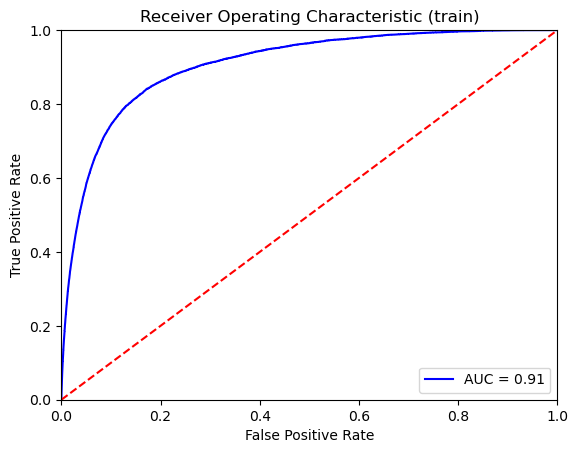

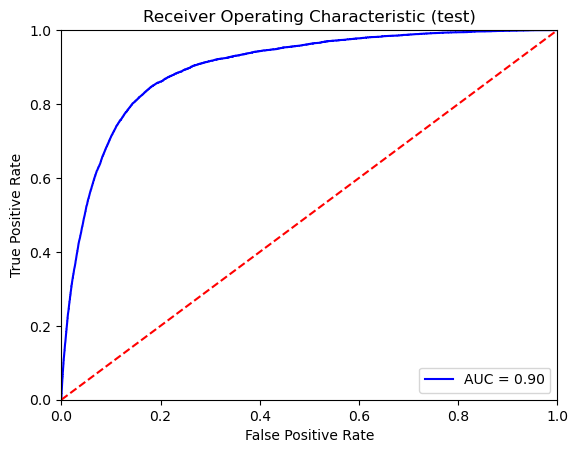

In [13]:
summary_auc(flag, train, test)

## Feature Analysis

### 10.1. Feature Importance

<Axes: title={'center': 'Feature Importances'}, xlabel='Features'>

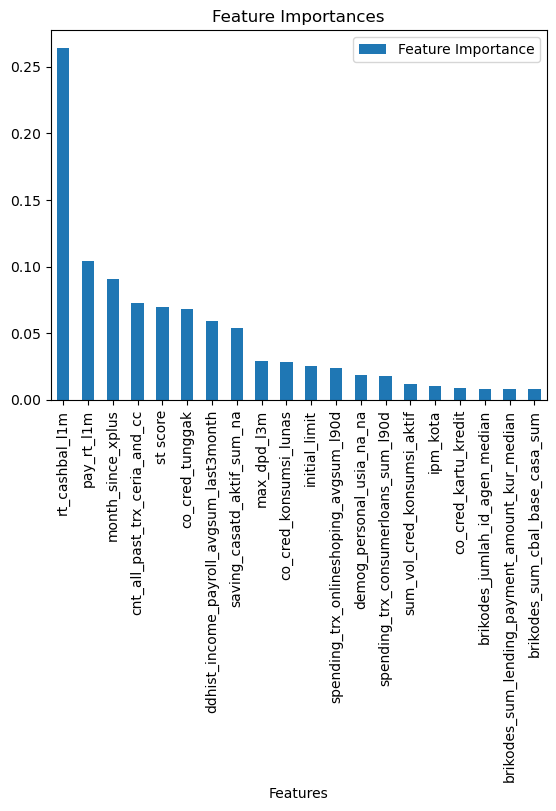

In [33]:
feature_importance = pd.Series(model.feature_importances_, train[feat_list].columns).sort_values(ascending = False).reset_index().rename(columns={'index': 'Features', 0: 'Feature Importance'})
feature_importance.set_index('Features').iloc[:20].plot(kind='bar', title='Feature Importances')

### 10.2. VIF (Multicolinearity)

In [34]:
%%time
    
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Features"] = feat_list
  
# calculating VIF for each f|eature
vif_data["VIF"] = [variance_inflation_factor(train[feat_list].fillna(0).values, i)
                          for i in range(len(feat_list))]

CPU times: user 19 s, sys: 3.84 s, total: 22.8 s
Wall time: 9.12 s


In [35]:
coefficients = feature_importance.merge(vif_data, on='Features', how='inner')
coefficients.sort_values(['Feature Importance', 'VIF'], ascending=[False, True])

Features  Feature Importance  \
0                                   rt_cashbal_l1m            0.264255   
1                                       pay_rt_l1m            0.104370   
2                                month_since_xplus            0.090826   
3                    cnt_all_past_trx_ceria_and_cc            0.072656   
4                                         st score            0.069495   
5                                  co_cred_tunggak            0.068018   
6          ddhist_income_payroll_avgsum_last3month            0.059082   
7                       saving_casatd_aktif_sum_na            0.054196   
8                                      max_dpd_l3m            0.028846   
9                           co_cred_konsumsi_lunas            0.028392   
10                                   initial_limit            0.025153   
11          spending_trx_onlineshoping_avgsum_l90d            0.023855   
12                       demog_personal_usia_na_na            0.018669   
13             spending_trx_consumerloans_sum_l90d            0.018045   
14                     sum_vol_cred_konsumsi_aktif            0.011686   
15                                        ipm_kota            0.010505   
16                            co_cred_kartu_kredit            0.008693   
17                  brikodes_jumlah_id_agen_median            0.008045   
18  brikodes_sum_lending_payment_amount_kur_median            0.007817   
19                 brikodes_sum_cbal_base_casa_sum            0.007691   
20                                        idm_mean            0.006711   
21              brikodes_frekuensi_trx_atm_all_sum            0.006640   
22         brikodes_frekuensi_transaksi_all_median            0.006354   

         VIF  
0   1.023045  
1   1.000015  
2   1.012397  
3   1.169234  
4   1.461862  
5   1.049284  
6   1.007336  
7   1.002739  
8   1.026567  
9   1.295698  
10  1.031680  
11  1.001226  
12  0.699431  
13  1.000160  
14  1.286539  
15  0.613739  
16  1.339468  
17  1.106797  
18  1.684921  
19  1.668015  
20  1.021528  
21  1.432996  
22  1.445923

### 10.3. Correlation

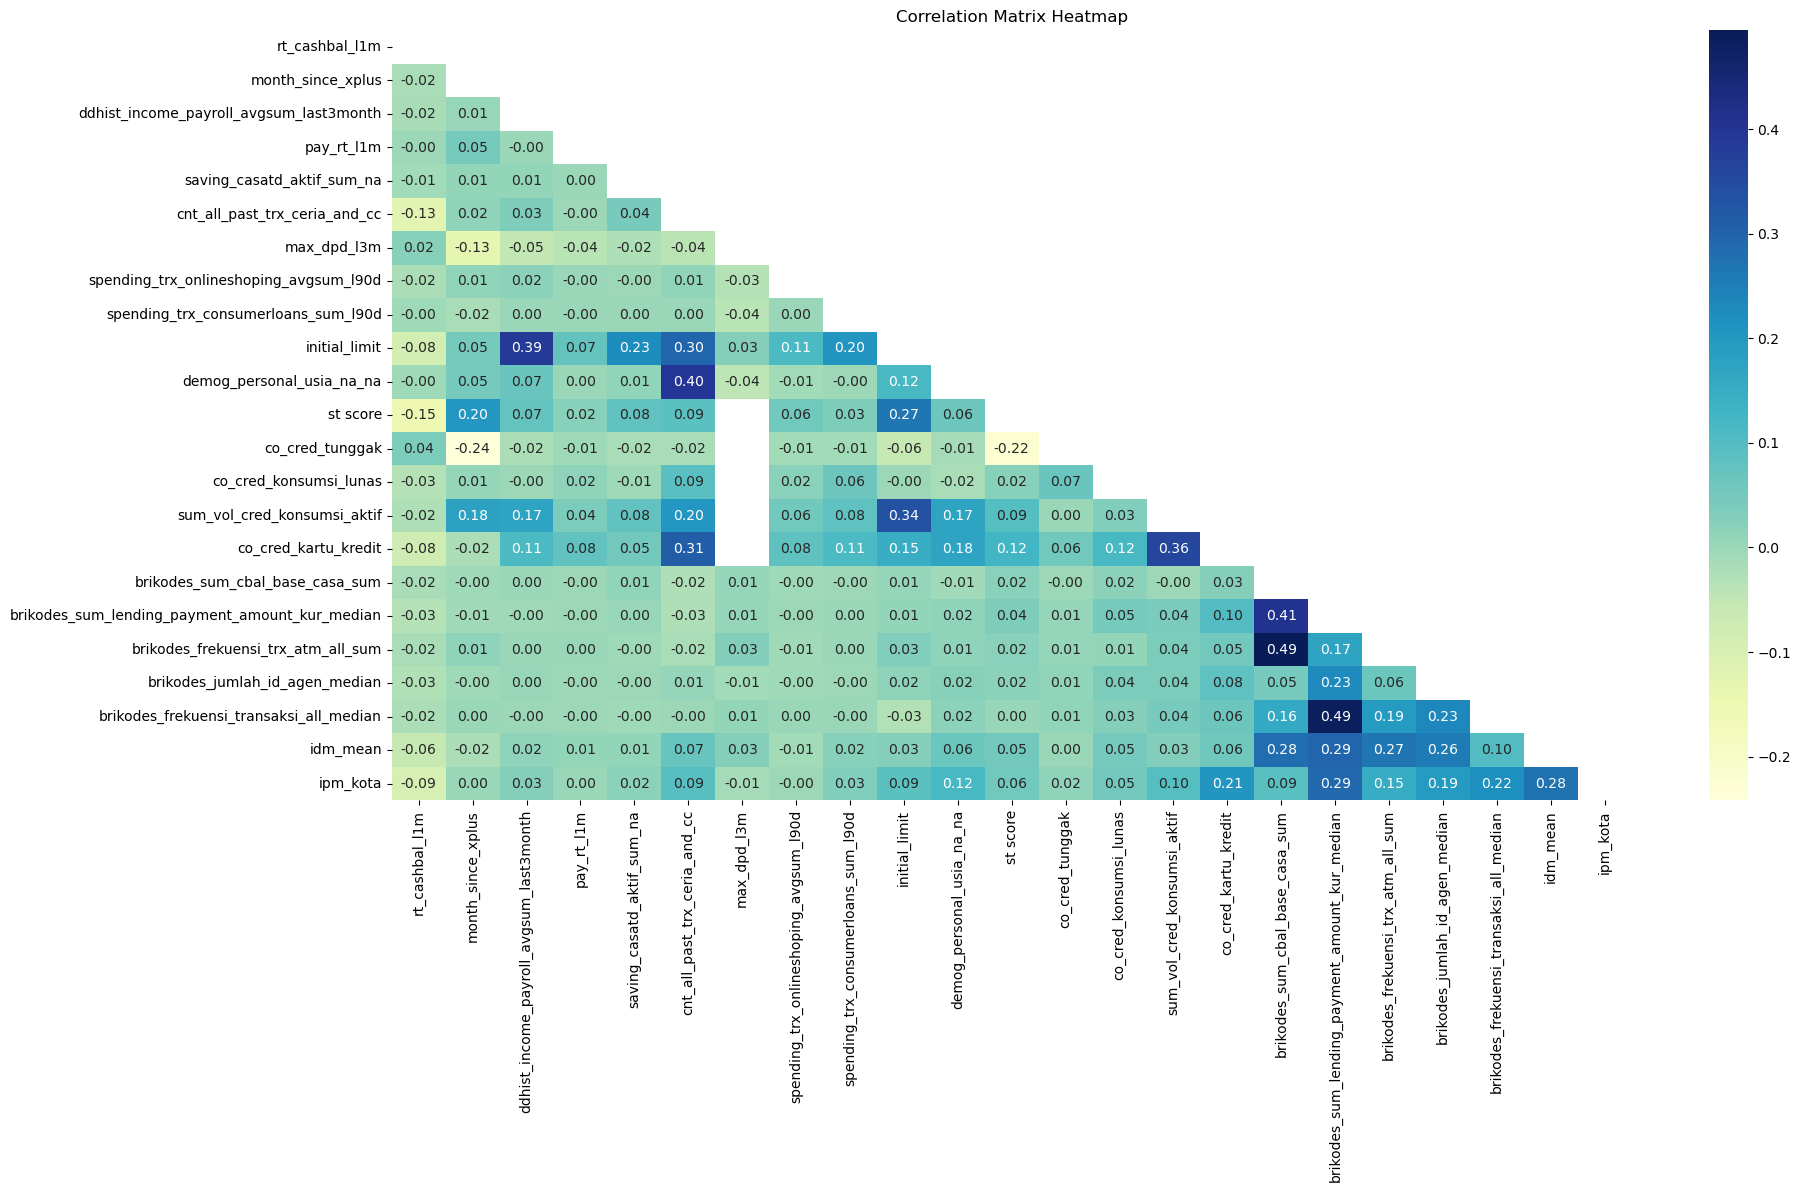

In [36]:
corr_matrix = train[feat_list].corr()

mask = np.triu(np.ones_like(corr_matrix))
plt.figure(figsize=(20, 10))
dataplot = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='YlGnBu', mask=mask)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Find High Correlated Features

In [37]:
threshold = 0.7
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

high_corr_pairs    

[]

## Pipeline

### 11.1. Selected Features

In [43]:
feat_list = [
    
    # BRI
    'rt_cashbal_l1m',
    'month_since_xplus',
    'ddhist_income_payroll_avgsum_last3month',
    'pay_rt_l1m',
    'saving_casatd_aktif_sum_na',
    'cnt_all_past_trx_ceria_and_cc',
    'max_dpd_l3m',
    'spending_trx_onlineshoping_avgsum_l90d',
    'spending_trx_consumerloans_sum_l90d',
    'initial_limit',
    'demog_personal_usia_na_na',

    # E-COMMERCE
    'st score',
    
    # SLIK
    'co_cred_tunggak',
    'co_cred_konsumsi_lunas',
    'sum_vol_cred_konsumsi_aktif',
    'co_cred_kartu_kredit',

    # AKTIVITAS LOKAL
    'brikodes_sum_cbal_base_casa_sum',
    'brikodes_sum_lending_payment_amount_kur_median',
    'brikodes_frekuensi_trx_atm_all_sum',
    
    # AGEN BRILINK
    'brikodes_jumlah_id_agen_median',
    'brikodes_frekuensi_transaksi_all_median',

    # INDEKS DESA DAN KOTA
    'idm_mean',
    'ipm_kota',
    
]

len(feat_list)

23

### 11.2. Final Features

In [436]:
feat_list = [
    
    # BRI
    'rt_cashbal_l1m',
    'month_since_xplus',
    'ddhist_income_payroll_avgsum_last3month',
    'pay_rt_l1m',
    'saving_casatd_aktif_sum_na',

    # E-COMMERCE
    'st score',
    
    # SLIK
    'co_cred_tunggak',
    'co_cred_konsumsi_lunas',
    'sum_vol_cred_konsumsi_aktif',
    'co_cred_kartu_kredit',

    # AKTIVITAS LOKAL
    'brikodes_sum_cbal_base_casa_sum',
    'brikodes_sum_lending_payment_amount_kur_median',
    'brikodes_frekuensi_trx_atm_all_sum',
    
    # AGEN BRILINK
    'brikodes_jumlah_id_agen_median',
    'brikodes_frekuensi_transaksi_all_median',

    # INDEKS DESA DAN KOTA
    'idm_mean',
    'ipm_kota',
    
]

len(feat_list)

17

### 11.3. Fitting

In [364]:
%%time

model = XGBClassifier(
    # base_score=0.5,
    # importance_type=None,
    # interaction_constraints='',
    # colsample_bylevel=1,
    # colsample_bynode=1,
    # colsample_bytree=1,
    # enable_categorical=False,
    # max_delta_step=2,
    max_depth=4, ##
    # min_child_weight=3, ##
    n_estimators=150, ##
    # num_parallel_tree=1,
    # scale_pos_weight=1,
    # subsample=0.8,
    eta=0.1, ##  #learning rate
    gamma=0.1, ## #Min loss reduction required to make a further partition on a leaf node
    reg_alpha=0.5, ##
    reg_lambda=0.5, ##
    
    random_state=11,
    seed=42,
    n_jobs=-1,
    eval_metric='auc',
    predictor='auto',
    booster='gbtree',
    verbosity=1,
    # gpu_id=-1,
    # tree_method='gpu_hist'
)

model.fit(train[feat_list], train[flag])

corr_threshold = 0.7
feat_list, coefficients = model_pipeline(train, test, model, feat_list, corr_threshold=corr_threshold, drop=['BRI'], sort_cat=True)
# final_feat_list = feature_selection(train, test, model, feat_list, len_feat=23)

## Final Binning

In [450]:
decile(test, flag, ascending=False, bin=5).reset_index()

decile  min_range  max_range    flag_0    flag_1  population  \
0       1   0.000053   0.004804  0.997774  0.002226       33697   
1       2   0.004805   0.009588  0.992996  0.007004       33696   
2       3   0.009588   0.019696  0.985518  0.014482       33696   
3       4   0.019697   0.082453  0.957888  0.042112       33696   
4       5   0.082462   0.872924  0.713239  0.286761       33697   

   actual_flag_0  actual_flag_1      mean  cum_flag_1_rate  
0          33622             75  0.006313         0.002226  
1          33460            236  0.019864         0.004615  
2          33208            488  0.041074         0.007904  
3          32277           1419  0.119434         0.016456  
4          24034           9663  0.813315         0.070518

## Proba to Score

In [14]:
xgb_train = train[['predict_proba', 'ds', flag, *feat_list]].copy()
xgb_test = test[['predict_proba', 'ds', flag, *feat_list]].copy()

In [15]:
xgb_train['logodds'] = xgb_train['predict_proba'].apply(lambda x: np.log(x / (1 - x)))
xgb_test['logodds'] = xgb_test['predict_proba'].apply(lambda x: np.log(x / (1 - x)))

In [16]:
xgb_data = pd.concat([xgb_train, xgb_test])

### 13.1. Get Min LogOdds

In [17]:
xgb_min_logodds = xgb_data['logodds'].min()
print(f'Min LogOdds: {xgb_min_logodds}')

Min LogOdds: -9.848527883958058


### 13.2. Get Max LogOdds

In [18]:
xgb_max_logodds = xgb_data['logodds'].max()
print(f'Max LogOdds: {xgb_max_logodds}')

Max LogOdds: 2.0463457646648413


### 13.3. Search A and B

In [19]:
# Apply the risk factor formula
anchor = 445.5
pdo = 32.05
basic_odd = 3
intercept = 0

# Priority Calc
basic_score = anchor + (-pdo / np.log(2)) * (np.log(basic_odd) + intercept)

# Get A & B
A_xgb = basic_score
B_xgb = -pdo/np.log(2)

#### Get A

In [20]:
print(f'A = {A_xgb}')

A = 394.7019518518869


#### Get B

In [21]:
print(f'B = {B_xgb}')

B = -46.23837606049128


### 13.4. Score Inference

In [22]:
xgb_train['xgb_score'] = A_xgb + B_xgb * xgb_train['logodds']
xgb_test['xgb_score'] = A_xgb + B_xgb * xgb_test['logodds']

In [23]:
decile(xgb_test, flag, ascending=True, pred='xgb_score', bin=10)

min_range   max_range    flag_0    flag_1  population  actual_flag_0  \
decile                                                                          
1       670.330452  850.081888  0.998694  0.001306       16849          16827   
2       641.311462  670.330229  0.996854  0.003146       16848          16795   
3       623.104101  641.304667  0.994065  0.005935       16848          16748   
4       609.139422  623.102752  0.991928  0.008072       16848          16712   
5       594.398521  609.138407  0.987120  0.012880       16848          16631   
6       575.376764  594.398276  0.983915  0.016085       16848          16577   
7       548.325932  575.374364  0.974240  0.025760       16848          16414   
8       506.112277  548.324702  0.941536  0.058464       16848          15863   
9       452.147236  506.106713  0.839031  0.160969       16848          14136   
10      305.597817  452.147236  0.587453  0.412547       16849           9898   

        actual_flag_1      mean  cum_flag_1_rate  
decile                                            
1                  22  0.001852         0.001306  
2                  53  0.004461         0.002226  
3                 100  0.008417         0.003462  
4                 136  0.011447         0.004615  
5                 217  0.018264         0.006268  
6                 271  0.022810         0.007904  
7                 434  0.036529         0.010455  
8                 985  0.082905         0.016456  
9                2712  0.228264         0.032513  
10               6951  0.585052         0.070518

<Axes: >

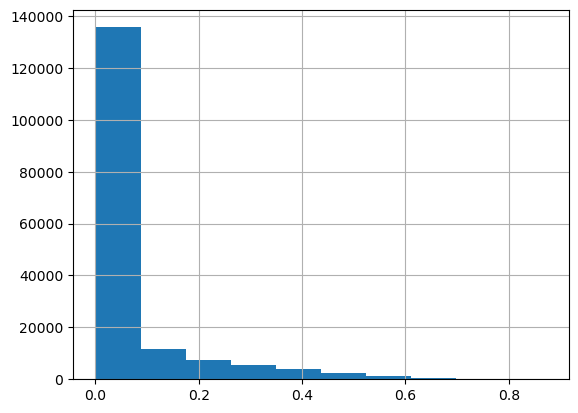

In [24]:
xgb_test['predict_proba'].hist()

<Axes: >

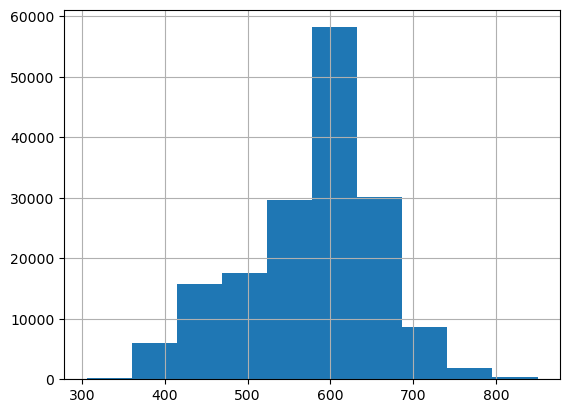

In [25]:
xgb_test['xgb_score'].hist()

In [26]:
score_bin = decile(pd.concat([xgb_train, xgb_test]), flag, ascending=True, pred='xgb_score', bin=5).reset_index()
score_bin['decile'] = score_bin['decile'].astype('int')
score_bin['kategori_skor'] = "Harus Ditingkatkan"
score_bin['kategori_skor'] = np.where(score_bin['decile'] == 1, 'Luar Biasa', score_bin['kategori_skor'])
score_bin['kategori_skor'] = np.where(score_bin['decile'] == 2, 'Sangat Baik', score_bin['kategori_skor'])
score_bin['kategori_skor'] = np.where(score_bin['decile'] == 3, 'Baik', score_bin['kategori_skor'])
score_bin['kategori_skor'] = np.where(score_bin['decile'] == 4, 'Cukup', score_bin['kategori_skor'])
score_bin['kategori_skor'] = np.where(score_bin['decile'] == 5, 'Harus Ditingkatkan', score_bin['kategori_skor'])
score_bin = score_bin.set_index("decile")
score_bin

min_range   max_range    flag_0    flag_1  population  actual_flag_0  \
decile                                                                          
1       643.963061  850.081888  0.998592  0.001408      111542         111385   
2       612.967957  643.962709  0.994863  0.005137      111542         110969   
3       584.334517  612.967583  0.988632  0.011368      111541         110273   
4       527.568087  584.334388  0.971697  0.028303      111542         108385   
5       300.082247  527.567920  0.770741  0.229259      111542          85970   

        actual_flag_1      mean  cum_flag_1_rate       kategori_skor  
decile                                                                
1                 157  0.005110         0.001408          Luar Biasa  
2                 573  0.018648         0.003272         Sangat Baik  
3                1268  0.041267         0.005971                Baik  
4                3157  0.102744         0.011554               Cukup  
5               25572  0.832232         0.055095  Harus Ditingkatkan

In [27]:
score_bin[['min_range', 'max_range', 'kategori_skor']]

min_range   max_range       kategori_skor
decile                                            
1       643.963061  850.081888          Luar Biasa
2       612.967957  643.962709         Sangat Baik
3       584.334517  612.967583                Baik
4       527.568087  584.334388               Cukup
5       300.082247  527.567920  Harus Ditingkatkan

## Sampling

In [3]:
df = pd.read_csv("final_hackathon_dataset_v2_20240724.csv")
df = df.drop(['ddhist_ratio_sumcreditdebit_na_last1month_last3month', 'ddhist_ratio_sumcreditdebit_na_last3month_last3month'], axis=1)
df.shape

(221235, 2125)

In [ ]:
df_cols = df.columns.to_list()
len(df_cols)

In [18]:
more_sample = pd.read_csv("briscore_resampling_v2.csv") # briscore_resampling.csv briscore_resampling_v2.csv
more_sample['ds'] = more_sample['ds_month'].astype('int')
more_sample.shape

(336474, 1052)

In [19]:
more_sample[['cifno', 'ds_month']].drop_duplicates().shape

(218394, 2)

In [20]:
additional = pd.read_parquet("briscore_additional.parquet").drop('event_date', axis=1)
additional['ds_month'] = additional['ds_month'].astype('int')
additional.shape

(218394, 5)

In [21]:
additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218394 entries, 0 to 218393
Data columns (total 5 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   cifno                                    218394 non-null  object 
 1   ds_month                                 218394 non-null  int64  
 2   spending_trx_consumerloans_sum_l90d      218394 non-null  float64
 3   spending_trx_onlineshoping_avgsum_l90d   218394 non-null  float64
 4   ddhist_income_payroll_avgsum_last3month  173596 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 8.3+ MB


In [28]:
more_sample = more_sample.merge(additional, on=['cifno', 'ds_month'], how='inner')
more_sample.shape

(336474, 3153)

In [13]:
brikodes = pd.read_csv("../../Data Hackathon/final_dataset_v5.csv")

In [23]:
more_sample = more_sample.merge(brikodes, on=['cifno'], how='left')

In [24]:
more_sample['ipm_kota'] = more_sample['ipm_kota_2023']
more_sample['idm_mean'] = more_sample['nilai_idm_2023_mean']
more_sample['brikodes_diff_sumamtcredit_sumamtdebit'] = more_sample['brikodes_sum_amt_credit_sum'] - more_sample['brikodes_sum_amt_debit_sum']
more_sample['brikodes_sum_cbal_base_casa_sum'] = more_sample['brikodes_sum_cbal_base_tabungan_sum'] + more_sample['brikodes_sum_cbal_base_giro_sum']
more_sample['brikodes_sum_cbal_base_casatd_sum'] = more_sample['brikodes_sum_cbal_base_tabungan_sum'] + more_sample['brikodes_sum_cbal_base_giro_sum'] + more_sample['brikodes_sum_cbal_base_deposito_sum']
more_sample['brikodes_frekuensi_trx_atm_all_sum'] = more_sample['brikodes_frekuensi_trx_atm_tarik_tunai_sum'] + more_sample['brikodes_frekuensi_trx_atm_transfer_sum'] + more_sample['brikodes_frekuensi_trx_atm_pembayaran_sum'] + more_sample['brikodes_frekuensi_trx_atm_pembelian_sum'] + more_sample['brikodes_frekuensi_trx_atm_setor_simpanan_sum']
more_sample['brikodes_sum_lending_payment_amount_all_sum'] =  more_sample['brikodes_sum_lending_payment_amount_mikro_sum'] + more_sample['brikodes_sum_lending_payment_amount_mikro_sum'] + more_sample['brikodes_sum_lending_payment_amount_seg_kecil_sum'] + more_sample['brikodes_sum_lending_payment_amount_menengah_sum'] + more_sample['brikodes_sum_lending_payment_amount_ritel_sum'] + more_sample['brikodes_sum_lending_payment_amount_korporasi_sum'] + more_sample['brikodes_sum_lending_payment_amount_kur_sum'] + more_sample['brikodes_sum_lending_payment_amount_kupedes_sum']

more_sample["st score"] = np.nan
more_sample["co_cred_tunggak"] = np.nan
more_sample["co_cred_konsumsi_lunas"] = np.nan
more_sample["sum_vol_cred_konsumsi_aktif"] = np.nan
more_sample["co_cred_kartu_kredit"] = np.nan
# more_sample["ddhist_income_payroll_avgsum_last3month"] = 0
# more_sample["spending_trx_onlineshoping_avgsum_l90d"] = 0
# more_sample["spending_trx_consumerloans_sum_l90d"] = 0
more_sample['dataset'] = 'DAVIN'

In [30]:
more_sample[df_cols].shape

(336474, 2125)

In [31]:
df = pd.concat([df[df_cols], more_sample[df_cols]])

In [52]:
df.to_csv("final_hackathon_dataset_v3_20240725.csv", index=False)

# BRI Score: Tips Score Model

In [390]:
def vif_coef(x_train_woe, feat_list, model, iv_ref):

    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = feat_list

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(x_train_woe[feat_list].fillna(0).values, i)
                              for i in range(len(feat_list))]

    df_ = pd.DataFrame(list(zip(feat_list, model.coef_[0])), columns=['feature', 'coefficient'])

    df_vif_coef = vif_data\
        .merge(df_, on='feature', how='inner')\
        .merge(iv_ref, on='feature', how='inner')
    df_vif_coef['Abs Coefficient'] = df_vif_coef['coefficient'].abs()
    df_vif_coef = df_vif_coef.rename(columns={'feature': 'Features', 'coefficient': 'Coefficient'})[['Features', 'VIF', 'Coefficient', 'Abs Coefficient', 'IV']]
    
    return df_vif_coef

In [391]:
logreg_train = train.copy()
logreg_test = test.copy()

## Final Features

In [415]:
feat_list = [
    
    # BRI
    'rt_cashbal_l1m',
    'month_since_xplus',
    'ddhist_income_payroll_avgsum_last3month',
    'pay_rt_l1m',
    'saving_casatd_aktif_sum_na',
    'cnt_all_past_trx_ceria_and_cc',
    'max_dpd_l3m',
    'spending_trx_onlineshoping_avgsum_l90d',
    'spending_trx_consumerloans_sum_l90d',
    'initial_limit',
    'demog_personal_usia_na_na',

    # E-COMMERCE
    'st score',
    
    # SLIK
    'co_cred_tunggak',
    'co_cred_konsumsi_lunas',
    'sum_vol_cred_konsumsi_aktif',
    'co_cred_kartu_kredit',

    # AKTIVITAS LOKAL
    'brikodes_sum_cbal_base_casa_sum',
    'brikodes_sum_lending_payment_amount_kur_median',
    'brikodes_frekuensi_trx_atm_all_sum',
    
    # AGEN BRILINK
    'brikodes_jumlah_id_agen_median',
    'brikodes_frekuensi_transaksi_all_median',

    # INDEKS DESA DAN KOTA
    'idm_mean',
    'ipm_kota',
    
]

len(feat_list)

23

In [416]:
X_train = logreg_train[feat_list].copy()
y_train = logreg_train[flag].copy()

X_test = logreg_test[feat_list].copy()
y_test = logreg_test[flag].copy()

## Bucketing

In [417]:
# uib = DecisionTreeBucketer(max_n_bins=10, variables=['ipm_kota'])

# uib.fit(X_train, y_train)
# uib.features_bucket_mapping_

In [418]:
bucket_maps = {
    "rt_cashbal_l1m": {
        "feature_name": "rt_cashbal_l1m",
        "type": "numerical",
        "map": [0.00099999, 0.199999, 0.499999],
        "right": True,
        "specials": {},
    },
    "month_since_xplus": {
        "feature_name": "month_since_xplus",
        "type": "numerical",
        "map": [1.99999, 2.99999, 4.99999, 7.99999, 11.99999],
        "right": True,
        "specials": {},
    },
    "ddhist_income_payroll_avgsum_last3month": {
        "feature_name": "ddhist_income_payroll_avgsum_last3month",
        "type": "numerical",
        "map": [268408.34375, 4356097.0, 6065481.25, 10945428.0],
        "right": True,
        "specials": {},
    },
    "pay_rt_l1m": {
        "feature_name": "pay_rt_l1m",
        "type": "numerical",
        "map": [0.099999, 0.399999, 0.99999],
        "right": True,
        "specials": {},
    },
    "saving_casatd_aktif_sum_na": {
        "feature_name": "saving_casatd_aktif_sum_na",
        "type": "numerical",
        "map": [109999, 249999, 1749999, 2999999, 5299999, 14999999],
        "right": True,
        "specials": {},
    },
    "cnt_all_past_trx_ceria_and_cc": {
        "feature_name": "cnt_all_past_trx_ceria_and_cc",
        "type": "numerical",
        "map": [7.5, 32.5, 66.5, 92.5, 118.5, 182.5, 249.5, 377.5, 598.5],
        "right": True,
        "specials": {},
    },
    "max_dpd_l3m": {
        "feature_name": "max_dpd_l3m",
        "type": "numerical",
        "map": [2.0, 3.0, 5.0, 11.0],
        "right": True,
        "specials": {},
    },
    "spending_trx_onlineshoping_avgsum_l90d": {
        "feature_name": "spending_trx_onlineshoping_avgsum_l90d",
        "type": "numerical",
        "map": [99999, 199999, 499999],
        "right": True,
        "specials": {},
    },
    "spending_trx_consumerloans_sum_l90d": {
        "feature_name": "spending_trx_consumerloans_sum_l90d",
        "type": "numerical",
        "map": [547190.5, 1273621.5, 2913740.5, 4069425.5, 6979358.5, 10897742.5, 19500420.0],
        "right": True,
        "specials": {},
    },
    "initial_limit": {
        "feature_name": "initial_limit",
        "type": "numerical",
        "map": [3700000.0, 4550000.0, 5550000.0, 7500000],
        "right": True,
        "specials": {},
    },
    "demog_personal_usia_na_na": {
        "feature_name": "demog_personal_usia_na_na",
        "type": "numerical",
        "map": [25.5, 28.5, 30.5, 32.5, 33.5, 37.5, 41.5, 46.5, 51.5],
        "right": True,
        "specials": {},
    },
    "st score": {
        "feature_name": "st score",
        "type": "numerical",
        "map": [593.5],
        "right": True,
        "specials": {},
    },
    "co_cred_tunggak": {
        "feature_name": "co_cred_tunggak",
        "type": "numerical",
        "map": [0],
        "right": True,
        "specials": {},
    },
    "co_cred_konsumsi_lunas": {
        "feature_name": "co_cred_konsumsi_lunas",
        "type": "numerical",
        "map": [10.5],
        "right": True,
        "specials": {},
    },
    "sum_vol_cred_konsumsi_aktif": {
        "feature_name": "sum_vol_cred_konsumsi_aktif",
        "type": "numerical",
        "map": [21442293.0],
        "right": True,
        "specials": {},
    },
    "co_cred_kartu_kredit": {
        "feature_name": "co_cred_kartu_kredit",
        "type": "numerical",
        "map": [0, 2],
        "right": True,
        "specials": {},
    },
    "brikodes_sum_cbal_base_casa_sum": {
        "feature_name": "brikodes_sum_cbal_base_casa_sum",
        "type": "numerical",
        "map": [101336521570.61194, 143082816159.3],
        "right": True,
        "specials": {},
    },
    "brikodes_sum_lending_payment_amount_kur_median": {
        "feature_name": "brikodes_sum_lending_payment_amount_kur_median",
        "type": "numerical",
        "map": [ 6271203835.0, 12142641989.0, 18396697148.0],
        "right": True,
        "specials": {},
    },
    "brikodes_frekuensi_trx_atm_all_sum": {
        "feature_name": "brikodes_frekuensi_trx_atm_all_sum",
        "type": "numerical",
        "map": [9935.5, 19034.0, 24229.0, 31143.0, 53392.0],
        "right": True,
        "specials": {},
    },
    "brikodes_jumlah_id_agen_median": {
        "feature_name": "brikodes_jumlah_id_agen_median",
        "type": "numerical",
        "map": [9.75, 13.75, 19.75, 68.25],
        "right": True,
        "specials": {},
    },
    "brikodes_frekuensi_transaksi_all_median": {
        "feature_name": "brikodes_frekuensi_transaksi_all_median",
        "type": "numerical",
        "map": [ 1451.5, 2670.0, 6221.0],
        "right": True,
        "specials": {},
    },
    "idm_mean": {
        "feature_name": "idm_mean",
        "type": "numerical",
        "map": [0.6803407915993538, 0.739986914212548, 0.76918125, 0.8142428571428572],
        "right": True,
        "specials": {},
    },
    "ipm_kota": {
        "feature_name": "ipm_kota",
        "type": "numerical",
        "map": [70.19, 72.84, 74.03, 78.64],
        "right": True,
        "specials": {},
    },
}

In [419]:
# non_bucket_feat = [
#     'co_cred_tunggak', 
#     'co_cred_kartu_kredit'
# ]

In [420]:
# bucket_feat = [
#     'rt_cashbal_l1m',
#     'month_since_xplus',
#     'ddhist_income_payroll_avgsum_last3month',
#     'pay_rt_l1m',
#     'saving_casatd_aktif_sum_na',
#     'cnt_all_past_trx_ceria_and_cc',
#     'max_dpd_l3m',
#     'spending_trx_onlineshoping_avgsum_l90d',
#     'spending_trx_consumerloans_sum_l90d',
#     'initial_limit',
#     'demog_personal_usia_na_na',
#     'st score',
#     'co_cred_konsumsi_lunas',
#     'sum_vol_cred_konsumsi_aktif',
#     'brikodes_sum_cbal_base_casa_sum',
#     'brikodes_sum_lending_payment_amount_kur_median',
#     'brikodes_frekuensi_trx_atm_all_sum',
#     'brikodes_jumlah_id_agen_median',
#     'brikodes_frekuensi_transaksi_all_median',
#     'idm_mean',
#     'ipm_kota'
# ]

In [421]:
# X_train = train[non_bucket_feat].copy()
# y_train = train[flag].copy()

# X_test = test[non_bucket_feat].copy()
# y_test = test[flag].copy()

In [422]:
tune_pipe = UserInputBucketer(bucket_maps)

pipe = make_pipeline(
    tune_pipe,
    # EqualFrequencyBucketer(n_bins=6, variables=non_bucket_feat),
    # DecisionTreeBucketer(max_n_bins=10, variables=feat_list)
)

sc_pipe = to_skorecard_pipeline(pipe)

## WoE Binning

In [423]:
woe_pipe = make_pipeline(
    sc_pipe,
    WoeEncoder()
)

x_train_woe = woe_pipe.fit_transform(X_train, y_train)
x_test_woe = woe_pipe.transform(X_test)

rt_cashbal_l1m


bucket                   label   Count  Count (%)  Non-event    Event  \
0      -1                 Missing   80239      20.61    67269.0  12970.0   
1       0      (-inf, 0.00099999]  224653      57.72   221389.0   3264.0   
2       1  (0.00099999, 0.199999]   36287       9.32    35468.0    819.0   
3       2    (0.199999, 0.499999]   28186       7.24    27379.0    807.0   
4       3         (0.499999, inf]   19862       5.10    18876.0    986.0   

   % Event  % Non-event  Event Rate    WoE     IV  
0    68.82        18.16       0.162  1.332  0.675  
1    17.32        59.77       0.015 -1.239  0.526  
2     4.35         9.58       0.023 -0.789  0.041  
3     4.28         7.39       0.029 -0.545  0.017  
4     5.23         5.10       0.050  0.027  0.000

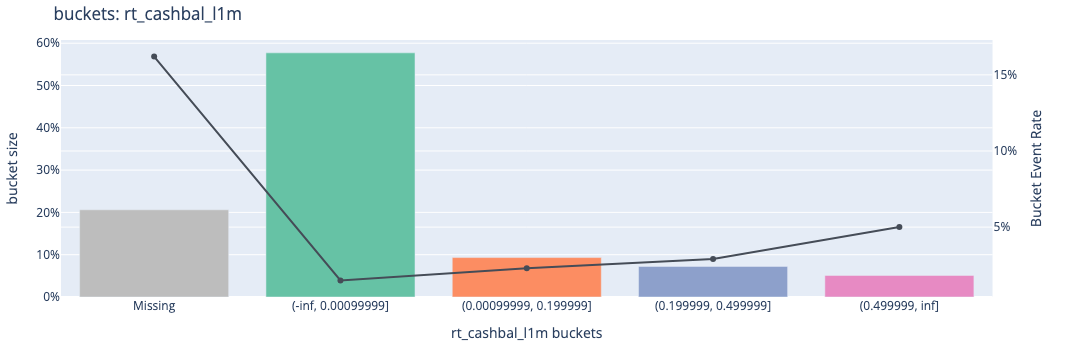

month_since_xplus


bucket                label   Count  Count (%)  Non-event    Event  \
0      -1              Missing  365108      93.80   348617.0  16491.0   
1       0      (-inf, 1.99999]    5999       1.54     4540.0   1459.0   
2       1   (1.99999, 2.99999]    1994       0.51     1750.0    244.0   
3       2   (2.99999, 4.99999]    3395       0.87     3122.0    273.0   
4       3   (4.99999, 7.99999]    4256       1.09     4071.0    185.0   
5       4  (7.99999, 11.99999]    5779       1.48     5637.0    142.0   
6       5      (11.99999, inf]    2696       0.69     2644.0     52.0   

   % Event  % Non-event  Event Rate    WoE     IV  
0    87.50        94.12       0.045 -0.073  0.005  
1     7.74         1.23       0.243  1.843  0.120  
2     1.29         0.47       0.122  1.011  0.008  
3     1.45         0.84       0.080  0.545  0.003  
4     0.98         1.10       0.043 -0.108  0.000  
5     0.75         1.52       0.025 -0.696  0.005  
6     0.28         0.71       0.019 -0.932  0.004

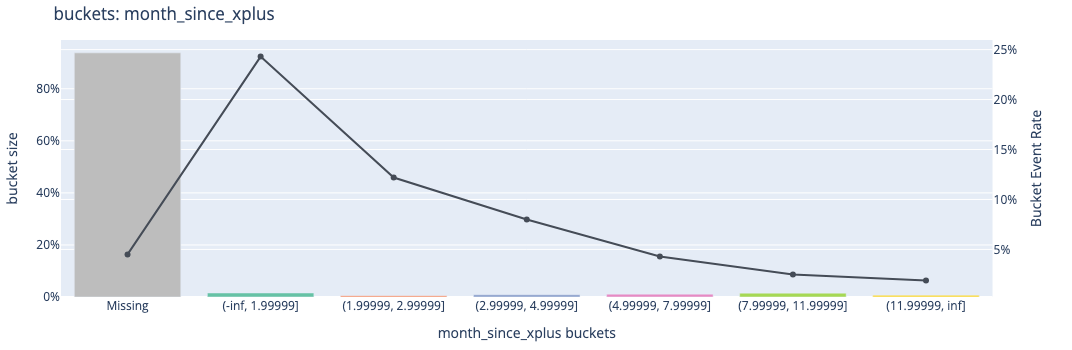

ddhist_income_payroll_avgsum_last3month


bucket                      label     Count  Count (%)  Non-event    Event  \
0      -1                    Missing       0.0       0.00        0.0      0.0   
1       0       (-inf, 268408.34375]  297247.0      76.37   280387.0  16860.0   
2       1  (268408.34375, 4356097.0]   19862.0       5.10    18818.0   1044.0   
3       2    (4356097.0, 6065481.25]   20095.0       5.16    19641.0    454.0   
4       3   (6065481.25, 10945428.0]   25552.0       6.56    25167.0    385.0   
5       4          (10945428.0, inf]   26471.0       6.80    26368.0    103.0   

   % Event  % Non-event  Event Rate    WoE     IV  
0     0.00         0.00         NaN    NaN    NaN  
1    89.46        75.70       0.057  0.167  0.023  
2     5.54         5.08       0.053  0.087  0.000  
3     2.41         5.30       0.023 -0.787  0.023  
4     2.04         6.79       0.015 -1.199  0.057  
5     0.55         7.12       0.004 -2.557  0.168

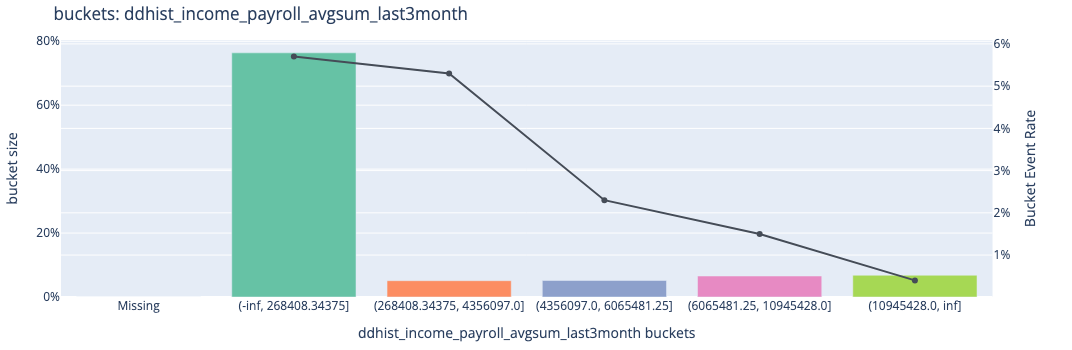

pay_rt_l1m


bucket                 label     Count  Count (%)  Non-event    Event  \
0      -1               Missing       0.0       0.00        0.0      0.0   
1       0      (-inf, 0.099999]  211147.0      54.25   194103.0  17044.0   
2       1  (0.099999, 0.399999]   63770.0      16.38    62852.0    918.0   
3       2   (0.399999, 0.99999]  105757.0      27.17   104935.0    822.0   
4       3        (0.99999, inf]    8553.0       2.20     8491.0     62.0   

   % Event  % Non-event  Event Rate    WoE     IV  
0     0.00         0.00         NaN    NaN    NaN  
1    90.44        52.41       0.081  0.546  0.208  
2     4.87        16.97       0.014 -1.247  0.151  
3     4.36        28.33       0.008 -1.870  0.448  
4     0.33         2.29       0.007 -1.926  0.038

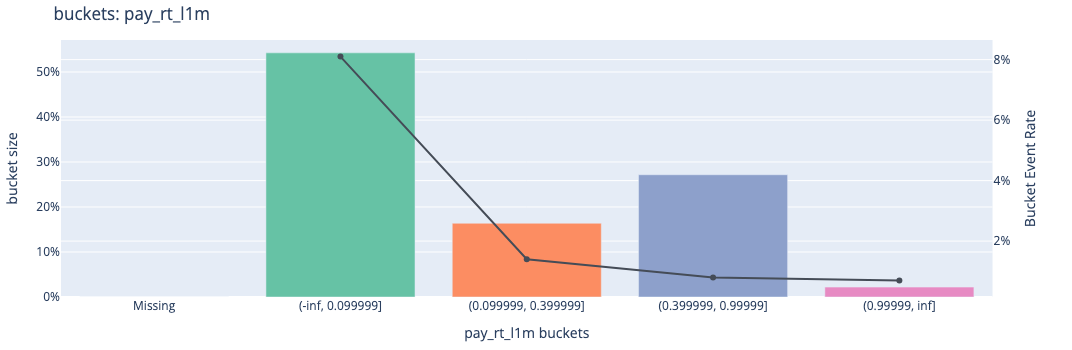

saving_casatd_aktif_sum_na


bucket                    label     Count  Count (%)  Non-event    Event  \
0      -1                  Missing       0.0       0.00        0.0      0.0   
1       0         (-inf, 109999.0]  156941.0      40.32   145347.0  11594.0   
2       1     (109999.0, 249999.0]   27922.0       7.17    26369.0   1553.0   
3       2    (249999.0, 1749999.0]   69971.0      17.98    66462.0   3509.0   
4       3   (1749999.0, 2999999.0]   22514.0       5.78    21730.0    784.0   
5       4   (2999999.0, 5299999.0]   23711.0       6.09    23067.0    644.0   
6       5  (5299999.0, 14999999.0]   32772.0       8.42    32321.0    451.0   
7       6        (14999999.0, inf]   55396.0      14.23    55085.0    311.0   

   % Event  % Non-event  Event Rate    WoE     IV  
0     0.00         0.00         NaN    NaN    NaN  
1    61.52        39.24       0.074  0.450  0.100  
2     8.24         7.12       0.056  0.147  0.002  
3    18.62        17.94       0.050  0.037  0.000  
4     4.16         5.87       0.035 -0.343  0.006  
5     3.42         6.23       0.027 -0.599  0.017  
6     2.39         8.73       0.014 -1.292  0.082  
7     1.65        14.87       0.006 -2.196  0.290

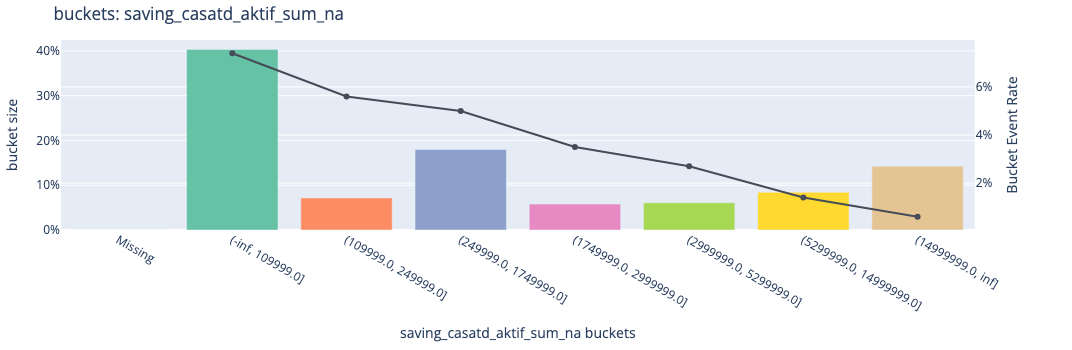

cnt_all_past_trx_ceria_and_cc


bucket           label    Count  Count (%)  Non-event    Event  % Event  \
0       -1         Missing      0.0       0.00        0.0      0.0     0.00   
1        0     (-inf, 7.5]  76939.0      19.77    64696.0  12243.0    64.96   
2        1     (7.5, 32.5]  28684.0       7.37    26813.0   1871.0     9.93   
3        2    (32.5, 66.5]  34958.0       8.98    33879.0   1079.0     5.73   
4        3    (66.5, 92.5]  25385.0       6.52    24775.0    610.0     3.24   
5        4   (92.5, 118.5]  23199.0       5.96    22668.0    531.0     2.82   
6        5  (118.5, 182.5]  46928.0      12.06    46031.0    897.0     4.76   
7        6  (182.5, 249.5]  35740.0       9.18    35169.0    571.0     3.03   
8        7  (249.5, 377.5]  44076.0      11.32    43537.0    539.0     2.86   
9        8  (377.5, 598.5]  36480.0       9.37    36138.0    342.0     1.81   
10       9    (598.5, inf]  36838.0       9.46    36675.0    163.0     0.86   

    % Non-event  Event Rate    WoE     IV  
0          0.00         NaN    NaN    NaN  
1         17.47       0.159  1.313  0.624  
2          7.24       0.065  0.316  0.009  
3          9.15       0.031 -0.468  0.016  
4          6.69       0.024 -0.724  0.025  
5          6.12       0.023 -0.774  0.026  
6         12.43       0.019 -0.959  0.074  
7          9.50       0.016 -1.141  0.074  
8         11.75       0.012 -1.412  0.126  
9          9.76       0.009 -1.679  0.133  
10         9.90       0.004 -2.432  0.220

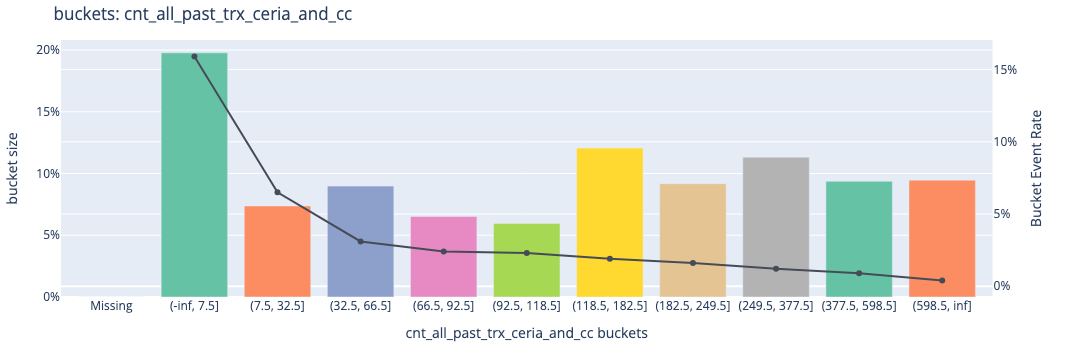

max_dpd_l3m


bucket        label   Count  Count (%)  Non-event    Event  % Event  \
0      -1      Missing  383966      98.65   366230.0  17736.0    94.11   
1       0  (-inf, 2.0]    1251       0.32     1070.0    181.0     0.96   
2       1   (2.0, 3.0]     827       0.21      701.0    126.0     0.67   
3       2   (3.0, 5.0]    1141       0.29      966.0    175.0     0.93   
4       3  (5.0, 11.0]    1257       0.32      953.0    304.0     1.61   
5       4  (11.0, inf]     785       0.20      461.0    324.0     1.72   

   % Non-event  Event Rate    WoE     IV  
0        98.88       0.046 -0.049  0.002  
1         0.29       0.145  1.206  0.008  
2         0.19       0.152  1.268  0.006  
3         0.26       0.153  1.274  0.009  
4         0.26       0.242  1.838  0.025  
5         0.12       0.413  2.626  0.042

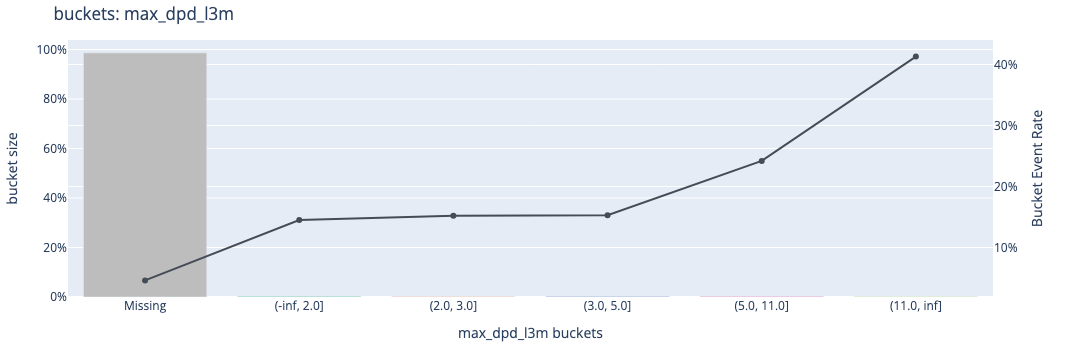

spending_trx_onlineshoping_avgsum_l90d


bucket                 label     Count  Count (%)  Non-event    Event  \
0      -1               Missing       0.0       0.00        0.0      0.0   
1       0       (-inf, 99999.0]  320882.0      82.44   304063.0  16819.0   
2       1   (99999.0, 199999.0]   24418.0       6.27    23513.0    905.0   
3       2  (199999.0, 499999.0]   23708.0       6.09    23035.0    673.0   
4       3       (499999.0, inf]   20219.0       5.19    19770.0    449.0   

   % Event  % Non-event  Event Rate    WoE     IV  
0     0.00         0.00         NaN    NaN    NaN  
1    89.24        82.09       0.052  0.083  0.006  
2     4.80         6.35       0.037 -0.278  0.004  
3     3.57         6.22       0.028 -0.553  0.015  
4     2.38         5.34       0.022 -0.805  0.024

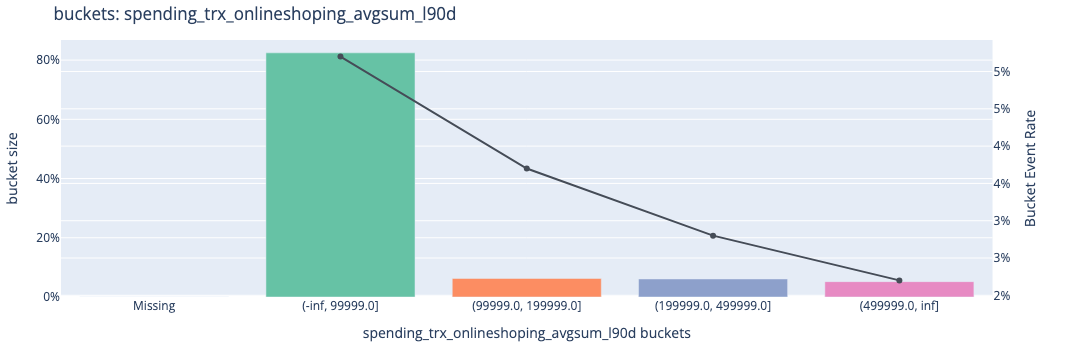

spending_trx_consumerloans_sum_l90d


bucket                     label     Count  Count (%)  Non-event    Event  \
0      -1                   Missing       0.0       0.00        0.0      0.0   
1       0          (-inf, 547190.5]  196601.0      50.51   182695.0  13906.0   
2       1     (547190.5, 1273621.5]   20171.0       5.18    18994.0   1177.0   
3       2    (1273621.5, 2913740.5]   36714.0       9.43    35265.0   1449.0   
4       3    (2913740.5, 4069425.5]   19630.0       5.04    19076.0    554.0   
5       4    (4069425.5, 6979358.5]   32770.0       8.42    32046.0    724.0   
6       5   (6979358.5, 10897742.5]   25467.0       6.54    25036.0    431.0   
7       6  (10897742.5, 19500420.0]   25831.0       6.64    25507.0    324.0   
8       7         (19500420.0, inf]   32043.0       8.23    31762.0    281.0   

   % Event  % Non-event  Event Rate    WoE     IV  
0     0.00         0.00         NaN    NaN    NaN  
1    73.79        49.33       0.071  0.403  0.099  
2     6.25         5.13       0.058  0.198  0.002  
3     7.69         9.52       0.039 -0.213  0.004  
4     2.94         5.15       0.028 -0.559  0.012  
5     3.84         8.65       0.022 -0.811  0.039  
6     2.29         6.76       0.017 -1.082  0.048  
7     1.72         6.89       0.013 -1.385  0.072  
8     1.49         8.58       0.009 -1.746  0.124

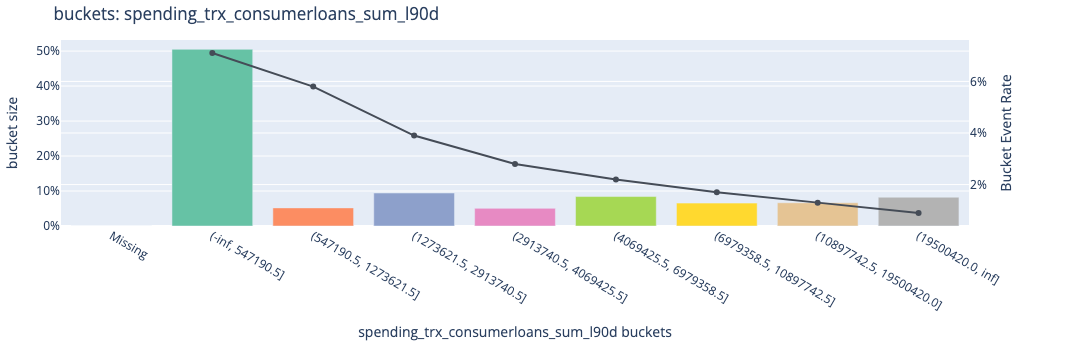

initial_limit


bucket                   label   Count  Count (%)  Non-event    Event  \
0      -1                 Missing  361163      92.79   345395.0  15768.0   
1       0       (-inf, 3700000.0]    8695       2.23     7159.0   1536.0   
2       1  (3700000.0, 4550000.0]    4503       1.16     3947.0    556.0   
3       2  (4550000.0, 5550000.0]    3604       0.93     3235.0    369.0   
4       3  (5550000.0, 7500000.0]    8102       2.08     7559.0    543.0   
5       4        (7500000.0, inf]    3160       0.81     3086.0     74.0   

   % Event  % Non-event  Event Rate    WoE     IV  
0    83.67        93.25       0.044 -0.109  0.010  
1     8.15         1.93       0.177  1.439  0.089  
2     2.95         1.07       0.123  1.020  0.019  
3     1.96         0.87       0.102  0.810  0.009  
4     2.88         2.04       0.067  0.346  0.003  
5     0.39         0.83       0.023 -0.739  0.003

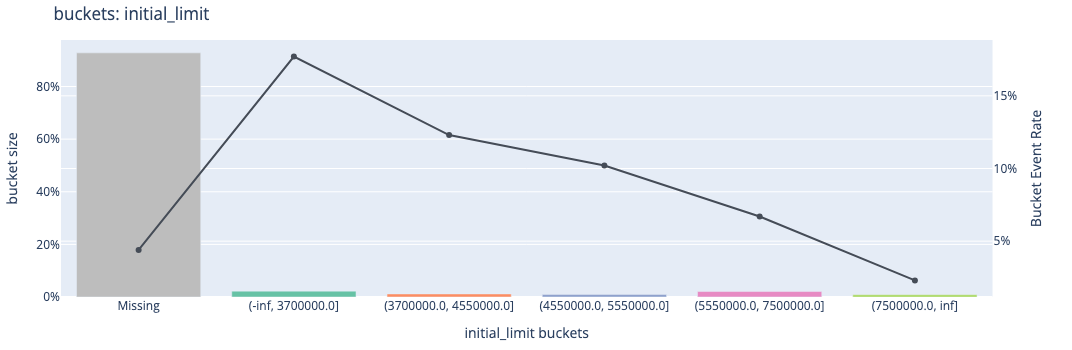

demog_personal_usia_na_na


bucket         label    Count  Count (%)  Non-event   Event  % Event  \
0       -1       Missing      0.0       0.00        0.0     0.0     0.00   
1        0  (-inf, 25.5]  29200.0       7.50    25993.0  3207.0    17.02   
2        1  (25.5, 28.5]  53752.0      13.81    50409.0  3343.0    17.74   
3        2  (28.5, 30.5]  41912.0      10.77    39690.0  2222.0    11.79   
4        3  (30.5, 32.5]  42749.0      10.98    40660.0  2089.0    11.08   
5        4  (32.5, 33.5]  20517.0       5.27    19587.0   930.0     4.93   
6        5  (33.5, 37.5]  65246.0      16.76    62554.0  2692.0    14.28   
7        6  (37.5, 41.5]  46073.0      11.84    44221.0  1852.0     9.83   
8        7  (41.5, 46.5]  37351.0       9.60    36022.0  1329.0     7.05   
9        8  (46.5, 51.5]  21900.0       5.63    21259.0   641.0     3.40   
10       9   (51.5, inf]  30527.0       7.84    29986.0   541.0     2.87   

    % Non-event  Event Rate    WoE     IV  
0          0.00         NaN    NaN    NaN  
1          7.02       0.110  0.886  0.089  
2         13.61       0.062  0.265  0.011  
3         10.72       0.053  0.096  0.001  
4         10.98       0.049  0.010  0.000  
5          5.29       0.045 -0.068  0.000  
6         16.89       0.041 -0.167  0.004  
7         11.94       0.040 -0.194  0.004  
8          9.73       0.036 -0.321  0.009  
9          5.74       0.029 -0.522  0.012  
10         8.10       0.018 -1.035  0.054

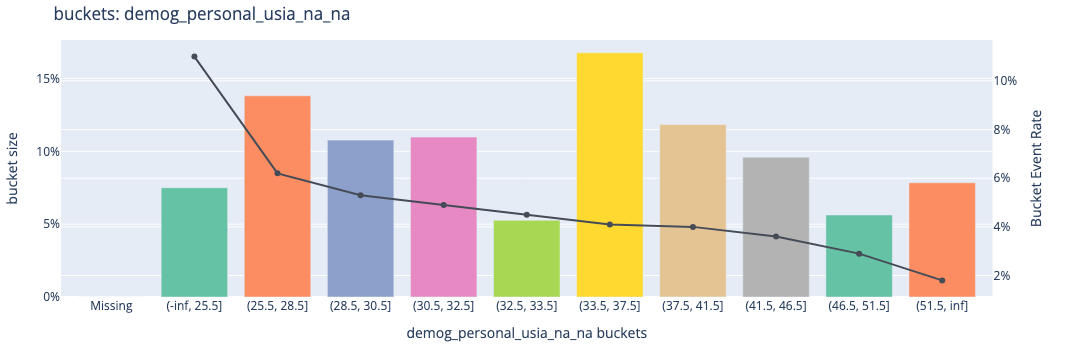

st score


bucket          label   Count  Count (%)  Non-event   Event  % Event  \
0      -1        Missing  332997      85.55   323050.0  9947.0    52.78   
1       0  (-inf, 593.5]   26591       6.83    19647.0  6944.0    36.85   
2       1   (593.5, inf]   29639       7.61    27684.0  1955.0    10.37   

   % Non-event  Event Rate    WoE     IV  
0        87.22       0.030 -0.502  0.173  
1         5.30       0.261  1.938  0.611  
2         7.47       0.066  0.328  0.010

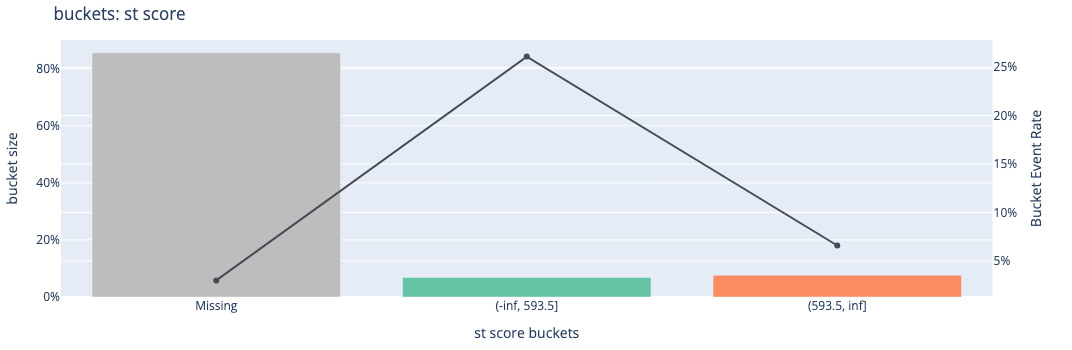

co_cred_tunggak


bucket        label     Count  Count (%)  Non-event    Event  % Event  \
0      -1      Missing       0.0       0.00        0.0      0.0     0.00   
1       0  (-inf, 0.0]  373723.0      96.02   359402.0  14321.0    75.99   
2       1   (0.0, inf]   15504.0       3.98    10979.0   4525.0    24.01   

   % Non-event  Event Rate    WoE     IV  
0         0.00         NaN    NaN    NaN  
1        97.04       0.038 -0.245  0.051  
2         2.96       0.292  2.092  0.440

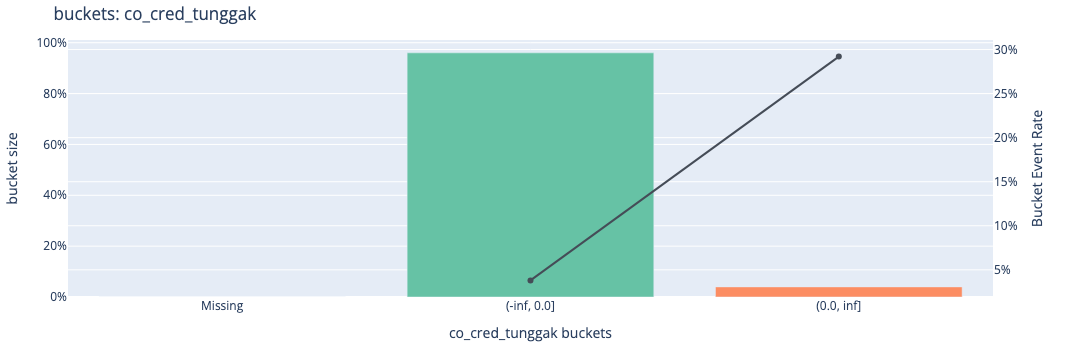

co_cred_konsumsi_lunas


bucket         label   Count  Count (%)  Non-event   Event  % Event  \
0      -1       Missing  332719      85.48   323578.0  9141.0    48.50   
1       0  (-inf, 10.5]   30485       7.83    24160.0  6325.0    33.56   
2       1   (10.5, inf]   26023       6.69    22643.0  3380.0    17.93   

   % Non-event  Event Rate    WoE     IV  
0        87.36       0.027 -0.588  0.229  
1         6.52       0.207  1.638  0.443  
2         6.11       0.130  1.076  0.127

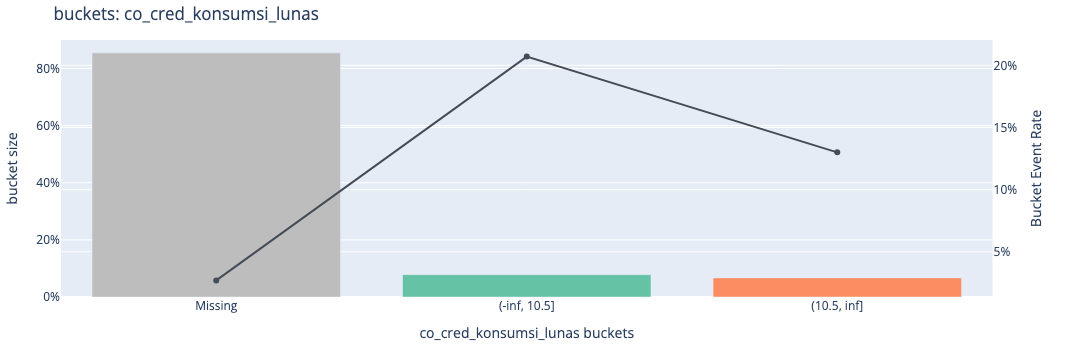

sum_vol_cred_konsumsi_aktif


bucket               label   Count  Count (%)  Non-event   Event  % Event  \
0      -1             Missing  332719      85.48   323578.0  9141.0    48.50   
1       0  (-inf, 21442293.0]   35997       9.25    29013.0  6984.0    37.06   
2       1   (21442293.0, inf]   20511       5.27    17790.0  2721.0    14.44   

   % Non-event  Event Rate    WoE     IV  
0        87.36       0.027 -0.588  0.229  
1         7.83       0.194  1.554  0.454  
2         4.80       0.133  1.101  0.106

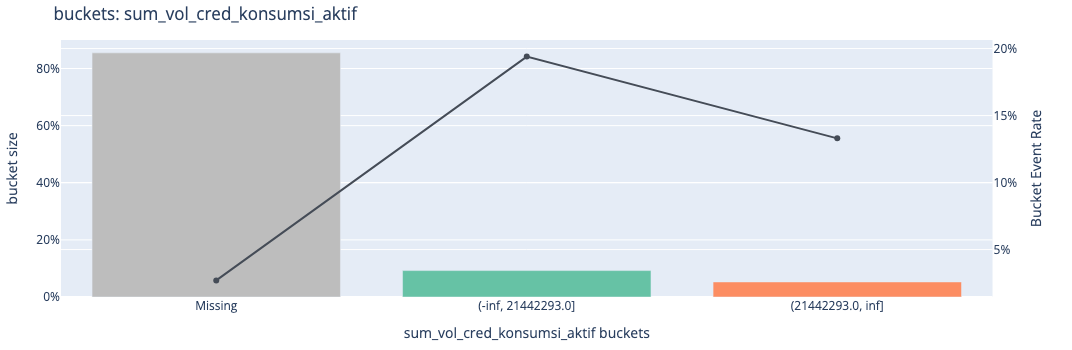

co_cred_kartu_kredit


bucket        label   Count  Count (%)  Non-event   Event  % Event  \
0      -1      Missing  332719      85.48   323578.0  9141.0    48.50   
1       0  (-inf, 0.0]   42878      11.02    34817.0  8061.0    42.77   
2       1   (0.0, 2.0]   10997       2.83     9600.0  1397.0     7.41   
3       2   (2.0, inf]    2633       0.68     2386.0   247.0     1.31   

   % Non-event  Event Rate    WoE     IV  
0        87.36       0.027 -0.588  0.229  
1         9.40       0.188  1.515  0.506  
2         2.59       0.127  1.051  0.051  
3         0.64       0.094  0.714  0.005

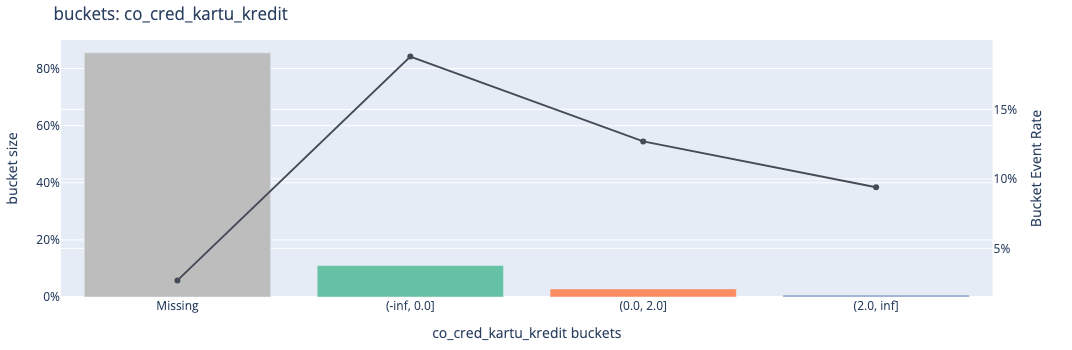

brikodes_sum_cbal_base_casa_sum


bucket                                 label   Count  Count (%)  Non-event  \
0      -1                               Missing   32264       8.29    29919.0   
1       0            (-inf, 101336521570.61194]  242818      62.38   231143.0   
2       1  (101336521570.61194, 143082816159.3]   38595       9.92    36785.0   
3       2                 (143082816159.3, inf]   75550      19.41    72534.0   

     Event  % Event  % Non-event  Event Rate    WoE     IV  
0   2345.0    12.44         8.08       0.073  0.432  0.019  
1  11675.0    61.95        62.41       0.048 -0.007  0.000  
2   1810.0     9.60         9.93       0.047 -0.033  0.000  
3   3016.0    16.00        19.58       0.040 -0.202  0.007

brikodes_sum_lending_payment_amount_kur_median


bucket                           label   Count  Count (%)  Non-event  \
0      -1                         Missing   32264       8.29    29919.0   
1       0            (-inf, 6271203835.0]  151821      39.01   143490.0   
2       1   (6271203835.0, 12142641989.0]   56365      14.48    53401.0   
3       2  (12142641989.0, 18396697148.0]   45690      11.74    43963.0   
4       3            (18396697148.0, inf]  103087      26.49    99608.0   

    Event  % Event  % Non-event  Event Rate    WoE     IV  
0  2345.0    12.44         8.08       0.073  0.432  0.019  
1  8331.0    44.21        38.74       0.055  0.132  0.007  
2  2964.0    15.73        14.42       0.053  0.087  0.001  
3  1727.0     9.16        11.87       0.038 -0.258  0.007  
4  3479.0    18.46        26.89       0.034 -0.376  0.032

brikodes_frekuensi_trx_atm_all_sum


bucket               label  Count  Count (%)  Non-event   Event  % Event  \
0      -1             Missing  32264       8.29    29919.0  2345.0    12.44   
1       0      (-inf, 9935.5]  93910      24.13    88606.0  5304.0    28.14   
2       1   (9935.5, 19034.0]  65812      16.91    62495.0  3317.0    17.60   
3       2  (19034.0, 24229.0]  32012       8.22    30527.0  1485.0     7.88   
4       3  (24229.0, 31143.0]  37436       9.62    35857.0  1579.0     8.38   
5       4  (31143.0, 53392.0]  70601      18.14    67761.0  2840.0    15.07   
6       5      (53392.0, inf]  57192      14.69    55216.0  1976.0    10.48   

   % Non-event  Event Rate    WoE     IV  
0         8.08       0.073  0.432  0.019  
1        23.92       0.056  0.163  0.007  
2        16.87       0.050  0.042  0.000  
3         8.24       0.046 -0.044  0.000  
4         9.68       0.042 -0.144  0.002  
5        18.29       0.040 -0.194  0.006  
6        14.91       0.035 -0.352  0.016

brikodes_jumlah_id_agen_median


bucket           label   Count  Count (%)  Non-event   Event  % Event  \
0      -1         Missing   32264       8.29    29919.0  2345.0    12.44   
1       0    (-inf, 9.75]   49223      12.65    45511.0  3712.0    19.70   
2       1   (9.75, 13.75]   28870       7.42    26809.0  2061.0    10.94   
3       2  (13.75, 19.75]   35476       9.11    33416.0  2060.0    10.93   
4       3  (19.75, 68.25]  161924      41.60   156167.0  5757.0    30.55   
5       4    (68.25, inf]   81470      20.93    78559.0  2911.0    15.45   

   % Non-event  Event Rate    WoE     IV  
0         8.08       0.073  0.432  0.019  
1        12.29       0.075  0.472  0.035  
2         7.24       0.071  0.413  0.015  
3         9.02       0.058  0.192  0.004  
4        42.16       0.036 -0.322  0.037  
5        21.21       0.036 -0.317  0.018

brikodes_frekuensi_transaksi_all_median


bucket             label   Count  Count (%)  Non-event   Event  % Event  \
0      -1           Missing   32264       8.29    29919.0  2345.0    12.44   
1       0    (-inf, 1451.5]  153074      39.33   144758.0  8316.0    44.13   
2       1  (1451.5, 2670.0]   69290      17.80    66081.0  3209.0    17.03   
3       2  (2670.0, 6221.0]   83911      21.56    80751.0  3160.0    16.77   
4       3     (6221.0, inf]   50688      13.02    48872.0  1816.0     9.64   

   % Non-event  Event Rate    WoE     IV  
0         8.08       0.073  0.432  0.019  
1        39.08       0.054  0.121  0.006  
2        17.84       0.046 -0.046  0.000  
3        21.80       0.038 -0.262  0.013  
4        13.20       0.036 -0.314  0.011

idm_mean


bucket                                    label   Count  Count (%)  \
0      -1                                  Missing  164014      42.14   
1       0               (-inf, 0.6803407915993538]   18318       4.71   
2       1  (0.6803407915993538, 0.739986914212548]   49872      12.81   
3       2          (0.739986914212548, 0.76918125]   30174       7.75   
4       3         (0.76918125, 0.8142428571428572]   47510      12.21   
5       4                (0.8142428571428572, inf]   79339      20.38   

   Non-event   Event  % Event  % Non-event  Event Rate    WoE     IV  
0   158970.0  5044.0    26.76        42.92       0.031 -0.472  0.076  
1    16863.0  1455.0     7.72         4.55       0.079  0.529  0.017  
2    46431.0  3441.0    18.26        12.54       0.069  0.376  0.022  
3    28139.0  2035.0    10.80         7.60       0.067  0.352  0.011  
4    44553.0  2957.0    15.69        12.03       0.062  0.266  0.010  
5    75425.0  3914.0    20.77        20.36       0.049  0.020  0.000

ipm_kota


bucket           label   Count  Count (%)  Non-event   Event  % Event  \
0      -1         Missing   32586       8.37    31993.0   593.0     3.15   
1       0   (-inf, 70.19]   18239       4.69    16409.0  1830.0     9.71   
2       1  (70.19, 72.84]   35091       9.02    31897.0  3194.0    16.95   
3       2  (72.84, 74.03]   49278      12.66    45954.0  3324.0    17.64   
4       3  (74.03, 78.64]   71081      18.26    67566.0  3515.0    18.65   
5       4    (78.64, inf]  182952      47.00   176562.0  6390.0    33.91   

   % Non-event  Event Rate    WoE     IV  
0         8.64       0.018 -1.008  0.055  
1         4.43       0.100  0.785  0.041  
2         8.61       0.091  0.677  0.056  
3        12.41       0.067  0.352  0.018  
4        18.24       0.049  0.022  0.000  
5        47.67       0.035 -0.341  0.047

In [36]:
for feat_ in feat_list:
    print(feat_)
    display(sc_pipe.bucket_table(feat_))
    display(sc_pipe.plot_bucket(feat_))

In [56]:
iv_ref = sc_pipe.summary()[['column', 'IV_score']].rename(columns={'column': 'feature', 'IV_score': 'IV'}).sort_values('IV', ascending=False)
feat_result = model_summary.T.reset_index()
feat_result.columns = [col.lower() for col in feat_result.columns]
feat_result = feat_result.rename(columns={'features': 'feature'})
iv_ref = iv_ref.merge(feat_result, on='feature', how='inner')

iv_ref

feature        IV  coefficient
0                    cnt_all_past_trx_ceria_and_cc  1.324003    -0.427535
1                                   rt_cashbal_l1m  1.258619    -0.319008
2                                       pay_rt_l1m  0.843974    -0.281733
3                           co_cred_konsumsi_lunas  0.798301    -0.627830
4                                         st score  0.793286    -0.275749
5                             co_cred_kartu_kredit  0.789222     0.532913
6                      sum_vol_cred_konsumsi_aktif  0.788433     0.178033
7                       saving_casatd_aktif_sum_na  0.496457    -0.528559
8                                  co_cred_tunggak  0.491084    -0.388905
9              spending_trx_consumerloans_sum_l90d  0.399337    -0.018576
10         ddhist_income_payroll_avgsum_last3month  0.270706    -0.546227
11                                        ipm_kota  0.218457    -0.195617
12                       demog_personal_usia_na_na  0.184016    -0.321828
13                               month_since_xplus  0.145454    -1.482490
14                                        idm_mean  0.135527     0.008694
15                                   initial_limit  0.133531    -0.477183
16                  brikodes_jumlah_id_agen_median  0.128372    -0.141436
17                                     max_dpd_l3m  0.089624    -0.821479
18  brikodes_sum_lending_payment_amount_kur_median  0.065897    -0.005666
19              brikodes_frekuensi_trx_atm_all_sum  0.049851    -0.152191
20         brikodes_frekuensi_transaksi_all_median  0.049726     0.041094
21          spending_trx_onlineshoping_avgsum_l90d  0.048710    -0.643613
22                 brikodes_sum_cbal_base_casa_sum  0.026207    -0.100514

In [57]:
df_bucket = pd.DataFrame()

for feat in feat_list:

    temp = sc_pipe.bucket_table(feat)
    temp['feature'] = feat

    temp['woe'] = np.log(temp['Non-event'] / temp['Non-event'].sum()) - np.log(temp['Event'] / temp['Event'].sum())

    temp = pd.merge(temp, iv_ref[['feature', 'coefficient']], on='feature', how='left')

    temp['score'] = temp['woe'] * temp['coefficient'] * B_logreg
    
    df_bucket = pd.concat([df_bucket, temp], axis=0)[['feature', 'bucket', 'label', 'Count', 'Count (%)', 'Non-event', 'Event', '% Event', '% Non-event', 'Event Rate', 'woe', 'coefficient', 'IV', 'score']]

df_bucket.columns = df_bucket.columns.str.lower()
df_bucket['bin_group'] = df_bucket['bucket'] + 1

In [58]:
# df_bucket.sort_values(["coefficient", "bucket"], ascending=[True, True]).to_excel("bucket_hackathon.xlsx", index=False)

df_bucket = df_bucket.sort_values(["coefficient", "bucket"], ascending=[True, True])

## Model Fitting

In [433]:
feat_list = [
    
    # BRI
    'rt_cashbal_l1m',
    'month_since_xplus',
    'ddhist_income_payroll_avgsum_last3month',
    'pay_rt_l1m',
    'saving_casatd_aktif_sum_na',
    'cnt_all_past_trx_ceria_and_cc',
    'max_dpd_l3m',
    'spending_trx_onlineshoping_avgsum_l90d',
    'spending_trx_consumerloans_sum_l90d',
    'initial_limit',
    'demog_personal_usia_na_na',

    # E-COMMERCE
    'st score',
    
    # SLIK
    'co_cred_tunggak',
    'co_cred_konsumsi_lunas',
    'sum_vol_cred_konsumsi_aktif',
    'co_cred_kartu_kredit',

    # AKTIVITAS LOKAL
    'brikodes_sum_cbal_base_casa_sum',
    'brikodes_sum_lending_payment_amount_kur_median',
    'brikodes_frekuensi_trx_atm_all_sum',
    
    # AGEN BRILINK
    'brikodes_jumlah_id_agen_median',
    'brikodes_frekuensi_transaksi_all_median',

    # INDEKS DESA DAN KOTA
    'idm_mean',
    'ipm_kota',
    
]

len(feat_list)

23

In [434]:
# # from skorecard.linear_model import LogisticRegression as sc_logreg

model = LogisticRegression(
    solver='saga',
    penalty="l2",
    C=0.01,
    max_iter=300,
    class_weight="balanced",
    random_state=42,
    fit_intercept=False,
    n_jobs=-1,
    # calculate_stats=True,
)

model.fit(x_train_woe[feat_list], logreg_train[flag])

LogisticRegression(C=0.01, class_weight='balanced', fit_intercept=False,
                   max_iter=300, n_jobs=-1, random_state=42, solver='saga')

In [435]:
# PREDICT
logreg_train['predict_proba'] = model.predict_proba(x_train_woe[feat_list])[:, 1]
logreg_test['predict_proba'] = model.predict_proba(x_test_woe[feat_list])[:, 1]

print_gini(logreg_train, logreg_test, flag=flag)

Gini train = 0.7523
Gini test = 0.7632


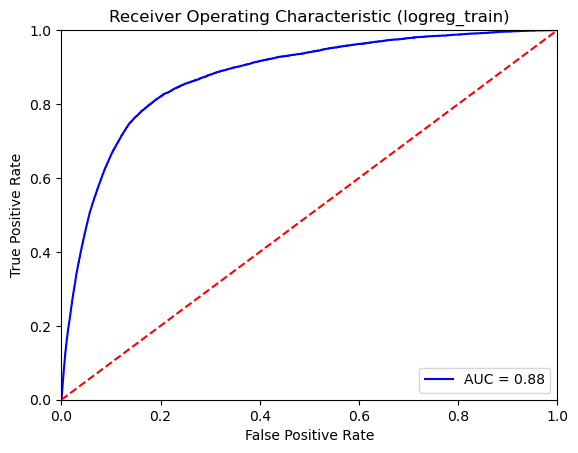

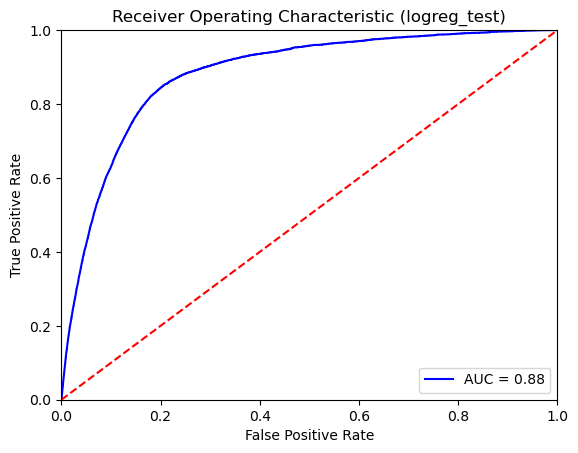

In [663]:
summary_auc(flag, logreg_train, logreg_test)

## Final Binning

In [44]:
decile(logreg_test, flag, ascending=False)

min_range  max_range    flag_0    flag_1  population  actual_flag_0  \
decile                                                                        
1        0.000949   0.047961  0.997389  0.002611       16849          16805   
2        0.047963   0.098488  0.994955  0.005045       16848          16763   
3        0.098491   0.149661  0.993590  0.006410       16848          16740   
4        0.149668   0.196364  0.990859  0.009141       16848          16694   
5        0.196364   0.253258  0.988663  0.011337       16848          16657   
6        0.253261   0.336336  0.982312  0.017688       16848          16550   
7        0.336337   0.499368  0.971213  0.028787       16848          16363   
8        0.499380   0.722232  0.925332  0.074668       16848          15590   
9        0.722234   0.841730  0.814696  0.185304       16848          13726   
10       0.841731   0.997751  0.635824  0.364176       16849          10713   

        actual_flag_1      mean  cum_flag_1_rate  
decile                                            
1                  44  0.003703         0.002611  
2                  85  0.007154         0.003828  
3                 108  0.009090         0.004689  
4                 154  0.012962         0.005802  
5                 191  0.016076         0.006909  
6                 298  0.025082         0.008705  
7                 485  0.040821         0.011574  
8                1258  0.105883         0.019461  
9                3122  0.262772         0.037888  
10               6136  0.516455         0.070518

## Proba to Score

In [45]:
logreg_train = logreg_train[['predict_proba', 'ds', flag, *feat_list]].copy()
logreg_test = logreg_test[['predict_proba', 'ds', flag, *feat_list]].copy()

In [46]:
logreg_train['logodds'] = logreg_train['predict_proba'].apply(lambda x: np.log(x / (1 - x)))
logreg_test['logodds'] = logreg_test['predict_proba'].apply(lambda x: np.log(x / (1 - x)))

In [47]:
logreg_data = pd.concat([logreg_train, logreg_test])

### 6.1. Get Min LogOdds

In [48]:
logreg_min_logodds = logreg_data['logodds'].min()
print(f'Min LogOdds: {logreg_min_logodds}')

Min LogOdds: -6.959276046730375


### 6.2. Get Max LogOdds

In [49]:
logreg_max_logodds = logreg_data['logodds'].max()
print(f'Max LogOdds: {logreg_max_logodds}')

Max LogOdds: 6.0948083793715835


### 6.3. Search A and B

In [50]:
# Apply the risk factor formula
anchor = 586
pdo = 29.204
basic_odd = 2
intercept = 0

# Priority Calc
basic_score = anchor + (-pdo / np.log(2)) * (np.log(basic_odd) + intercept)

# Get A & B
A_logreg = basic_score
B_logreg = -pdo/np.log(2)

#### Get A

In [51]:
print(f'A = {A_logreg}')

A = 556.796


#### Get B

In [52]:
print(f'B = {B_logreg}')

B = -42.13246597412129


### 6.4. Score Inference

In [53]:
logreg_train['logreg_score'] = A_logreg + B_logreg * logreg_train['logodds']
logreg_test['logreg_score'] = A_logreg + B_logreg * logreg_test['logodds']

In [54]:
decile(logreg_test, flag, ascending=True, pred='logreg_score', bin=10)

min_range   max_range    flag_0    flag_1  population  actual_flag_0  \
decile                                                                          
1       682.697152  850.007461  0.997389  0.002611       16849          16805   
2       650.083125  682.695439  0.994955  0.005045       16848          16763   
3       629.991107  650.081629  0.993590  0.006410       16848          16740   
4       616.168083  629.988726  0.990859  0.009141       16848          16694   
5       602.354274  616.168083  0.988663  0.011337       16848          16657   
6       585.432014  602.353559  0.982312  0.017688       16848          16550   
7       556.902455  585.431815  0.971213  0.028787       16848          16363   
8       516.535997  556.900496  0.925332  0.074668       16848          15590   
9       486.386037  516.535506  0.814696  0.185304       16848          13726   
10      300.006693  486.385865  0.635824  0.364176       16849          10713   

        actual_flag_1      mean  cum_flag_1_rate  
decile                                            
1                  44  0.003703         0.002611  
2                  85  0.007154         0.003828  
3                 108  0.009090         0.004689  
4                 154  0.012962         0.005802  
5                 191  0.016076         0.006909  
6                 298  0.025082         0.008705  
7                 485  0.040821         0.011574  
8                1258  0.105883         0.019461  
9                3122  0.262772         0.037888  
10               6136  0.516455         0.070518

### 6.5. Build Scorecard

In [55]:
model_summary = vif_coef(x_train_woe, feat_list, model, iv_ref).sort_values('Coefficient')[['Features', 'Coefficient']].set_index('Features').T
model_summary

Features     month_since_xplus  max_dpd_l3m  \
Coefficient           -1.48249    -0.821479   

Features     spending_trx_onlineshoping_avgsum_l90d  co_cred_konsumsi_lunas  \
Coefficient                               -0.643613                -0.62783   

Features     ddhist_income_payroll_avgsum_last3month  \
Coefficient                                -0.546227   

Features     saving_casatd_aktif_sum_na  initial_limit  \
Coefficient                   -0.528559      -0.477183   

Features     cnt_all_past_trx_ceria_and_cc  co_cred_tunggak  \
Coefficient                      -0.427535        -0.388905   

Features     demog_personal_usia_na_na  rt_cashbal_l1m  pay_rt_l1m  st score  \
Coefficient                  -0.321828       -0.319008   -0.281733 -0.275749   

Features     ipm_kota  brikodes_frekuensi_trx_atm_all_sum  \
Coefficient -0.195617                           -0.152191   

Features     brikodes_jumlah_id_agen_median  brikodes_sum_cbal_base_casa_sum  \
Coefficient                       -0.141436                        -0.100514   

Features     spending_trx_consumerloans_sum_l90d  \
Coefficient                            -0.018576   

Features     brikodes_sum_lending_payment_amount_kur_median  idm_mean  \
Coefficient                                       -0.005666  0.008694   

Features     brikodes_frekuensi_transaksi_all_median  \
Coefficient                                 0.041094   

Features     sum_vol_cred_konsumsi_aktif  co_cred_kartu_kredit  
Coefficient                     0.178033              0.532913

In [679]:
risk_factor = pd.DataFrame()

for feat_ in feat_list:

    feat_table = sc_pipe.bucket_table(feat_)
    feat_table['WoE'] = np.log((feat_table['Non-event'] / feat_table['Non-event'].sum()) / (feat_table['Event'] / feat_table['Event'].sum()))
    
    feat_table['feature'] = feat_
    feat_table['coef'] = model_summary[feat_].values[0]
    feat_table['woexcoef'] = feat_table['WoE'] * model_summary[feat_].values[0]
    feat_table['sum_woexcoef'] = feat_table['woexcoef'].sum(axis=0)

    risk_factor = pd.concat([risk_factor, feat_table])

risk_factor['bin'] = risk_factor['label']
risk_factor['count'] = risk_factor['Count']
risk_factor['co_bad'] = risk_factor['Event']
risk_factor['bad_rate'] = risk_factor['Event Rate']
risk_factor['woe'] = risk_factor['WoE']
risk_factor['score'] = B_logreg * risk_factor['woexcoef']

risk_factor = risk_factor[['feature', 'bin', 'count', 'co_bad', 'bad_rate', 'woe', 'coef', 'woexcoef', 'sum_woexcoef', 'score']]
risk_factor = risk_factor.dropna(subset=['woe'])
risk_factor['bin'] = np.where(risk_factor['bin'] == 'Missing', np.nan, risk_factor['bin'])
risk_factor['basic_score'] = A_logreg

In [680]:
# risk_factor[['basic_score', 'feature', 'bin', 'count', 'co_bad', 'bad_rate', 'woe', 'coef', 'score']].to_excel('./saved_model/briscore_hackathon_risk_factor.xlsx', index=False)

risk_factor = pd.read_excel('./saved_model/briscore_hackathon_risk_factor.xlsx')
risk_factor.head()

basic_score         feature                     bin   count  co_bad  \
0      556.796  rt_cashbal_l1m                     NaN   80239   12970   
1      556.796  rt_cashbal_l1m      (-inf, 0.00099999]  224653    3264   
2      556.796  rt_cashbal_l1m  (0.00099999, 0.199999]   36287     819   
3      556.796  rt_cashbal_l1m    (0.199999, 0.499999]   28186     807   
4      556.796  rt_cashbal_l1m         (0.499999, inf]   19862     986   

   bad_rate       woe      coef      score  
0     0.162 -1.332171 -0.319008 -17.905178  
1     0.015  1.238736 -0.319008  16.649361  
2     0.023  0.790071 -0.319008  10.619023  
3     0.029  0.545976 -0.319008   7.338250  
4     0.050 -0.026241 -0.319008  -0.352699

# Tips Score

In [141]:
feat_dict = {
    'month_since_xplus': 1,
    'pay_rt_l1m': 2,
    'max_dpd_l3m': 3,
    'saving_casatd_aktif_sum_na': 4,
    'cnt_all_past_trx_ceria_and_cc': 5,
    'spending_trx_onlineshoping_avgsum_l90d': 6,
    'co_cred_tunggak': 7,
}

In [142]:
df_feat = pd.DataFrame(list(feat_dict.items()), columns=['feature_name', 'feature_id'])
df_feat

feature_name  feature_id
0                       month_since_xplus           1
1                              pay_rt_l1m           2
2                             max_dpd_l3m           3
3              saving_casatd_aktif_sum_na           4
4           cnt_all_past_trx_ceria_and_cc           5
5  spending_trx_onlineshoping_avgsum_l90d           6
6                         co_cred_tunggak           7

## Tips Pertahankan Score

In [59]:
def generate_random_string(length=10):
    letters_and_digits = string.ascii_letters + string.digits
    return ''.join(random.choice(letters_and_digits) for i in range(length))

# Set to keep track of generated IDs to ensure uniqueness
generated_ids = set()

# Function to create a unique id of a given length
def create_unique_id(length=10):
    while True:
        random_id = generate_random_string(length)
        if random_id not in generated_ids:
            generated_ids.add(random_id)
            return random_id

# Apply the function to create the 'id' column
xgb_test['cifno'] = [create_unique_id(10) for _ in range(len(xgb_test))]
xgb_test['cifno'] = xgb_test['cifno'].str.upper()

In [60]:
def get_diff_score_logreg(feat_val, df_bucket, feat, target_val):
    logreg_score_now = []
    logreg_score_target = []
    
    upper_bound = df_bucket[df_bucket['feature'] == feat]['bin_group'].max()
    
    for index, row in df_bucket[df_bucket['feature'] == feat].iterrows():
    
        if row['bin_group'] == 0:
            if np.isnan(feat_val) == True:
                logreg_score_now.append(row['score'])
    
            if np.isnan(target_val) == True:
                logreg_score_target.append(row['score'])
    
            continue
    
        if row['label'].endswith(']'):
            
            interval_raw = row['label'].replace('(', '').replace(')', '').replace('[', '').replace(']', '')
            interval_raw = ''.join(interval_raw.split())
            interval_raw = interval_raw.split(',')
        
            interval = float(interval_raw[1])
            
            if row['bin_group'] != upper_bound:
        
                if np.isnan(feat_val) == False and feat_val <= interval and len(logreg_score_now) == 0:
                    logreg_score_now.append(row['score'])
        
                if np.isnan(target_val) == False and target_val <= interval and len(logreg_score_target) == 0:
                    logreg_score_target.append(row['score'])
        
            else:
        
                if np.isnan(feat_val) == False and feat_val > float(interval_raw[0]) and len(logreg_score_now) == 0:
                    logreg_score_now.append(row['score'])
        
                if np.isnan(target_val) == False and target_val > float(interval_raw[0]) and len(logreg_score_target) == 0:
                    logreg_score_target.append(row['score'])
        else:
            interval_raw = row['label'].replace('(', '').replace(')', '').replace('[', '').replace(']', '')
            interval_raw = ''.join(interval_raw.split())
            interval_raw = interval_raw.split(',')
        
            interval = float(interval_raw[1])
            
            if row['bin_group'] != upper_bound:
        
                if np.isnan(feat_val) == False and feat_val < interval and len(logreg_score_now) == 0:
                    logreg_score_now.append(row['score'])
        
                if np.isnan(target_val) == False and target_val < interval and len(logreg_score_target) == 0:
                    logreg_score_target.append(row['score'])
        
            else:
        
                if np.isnan(feat_val) == False and feat_val > float(interval_raw[0]) and len(logreg_score_now) == 0:
                    logreg_score_now.append(row['score'])
        
                if np.isnan(target_val) == False and target_val > float(interval_raw[0]) and len(logreg_score_target) == 0:
                    logreg_score_target.append(row['score'])
    
    diff_logreg = logreg_score_target[0] - logreg_score_now[0]

    return diff_logreg

def check_conditions(row, conditions, original_desired_output):
    meets_conditions = []
    not_meets_conditions = []
    
    desired_output_lvl_1 = original_desired_output.copy()
    desired_output_lvl_1['spending_trx_onlineshoping_avgsum_l90d'] = 500000
    desired_output_lvl_1['saving_casatd_aktif_sum_na'] = 3000000
    desired_output_lvl_1['cnt_all_past_trx_ceria_and_cc'] = 33

    desired_output_lvl_2 = desired_output_lvl_1.copy()
    desired_output_lvl_2['saving_casatd_aktif_sum_na'] = 5300000
    desired_output_lvl_2['cnt_all_past_trx_ceria_and_cc'] = 67

    desired_output_lvl_3 = desired_output_lvl_2.copy()
    desired_output_lvl_3['saving_casatd_aktif_sum_na'] = 15000000
    desired_output_lvl_3['cnt_all_past_trx_ceria_and_cc'] = 93
    
    for col, condition in conditions.items():
        if col == 'spending_trx_onlineshoping_avgsum_l90d':
            # Check initial condition
            if condition(row[col]):
                # Recheck the condition with updated local_desired_output
                if row[col] >= desired_output_lvl_1[col]:
                    meets_conditions.append({"feature_name": col})
                else:
                    inc_val = get_diff_score_logreg(row[col], df_bucket, feat=col, target_val=desired_output_lvl_1[col])
                    
                    rec_feat = {
                        "feature_name": col,
                        "curr_feature_value": f'{row[col]:.10g}',
                        "rec_feature_value": f'{desired_output_lvl_1[col]:.10g}',
                        "peningkatan_skor": math.ceil(inc_val),
                    }
            
                    not_meets_conditions.append(rec_feat)
            else:

                inc_val = get_diff_score_logreg(row[col], df_bucket, feat=col, target_val=original_desired_output[col])
                    
                rec_feat = {
                    "feature_name": col,
                    "curr_feature_value": f'{row[col]:.10g}',
                    "rec_feature_value": f'{original_desired_output[col]:.10g}',
                    "peningkatan_skor": math.ceil(inc_val),
                }
        
                not_meets_conditions.append(rec_feat)


                

        elif col in ['saving_casatd_aktif_sum_na', 'cnt_all_past_trx_ceria_and_cc']:
            # Check initial condition
            if condition(row[col]):
                # Recheck the condition with updated local_desired_output
                if row[col] >= desired_output_lvl_1[col]:

                    if row[col] >= desired_output_lvl_2[col]:
                        
                        if row[col] >= desired_output_lvl_3[col]:
                            meets_conditions.append({"feature_name": col})
                        else:
                            inc_val = get_diff_score_logreg(row[col], df_bucket, feat=col, target_val=desired_output_lvl_3[col])
                    
                            rec_feat = {
                                "feature_name": col,
                                "curr_feature_value": f'{row[col]:.10g}',
                                "rec_feature_value": f'{desired_output_lvl_3[col]:.10g}',
                                "peningkatan_skor": math.ceil(inc_val),
                            }
                    
                            not_meets_conditions.append(rec_feat)
                            
                    else:
                        inc_val = get_diff_score_logreg(row[col], df_bucket, feat=col, target_val=desired_output_lvl_2[col])
                    
                        rec_feat = {
                            "feature_name": col,
                            "curr_feature_value": f'{row[col]:.10g}',
                            "rec_feature_value": f'{desired_output_lvl_2[col]:.10g}',
                            "peningkatan_skor": math.ceil(inc_val),
                        }
                
                        not_meets_conditions.append(rec_feat)
                    
                else:
                    inc_val = get_diff_score_logreg(row[col], df_bucket, feat=col, target_val=desired_output_lvl_1[col])
                    
                    rec_feat = {
                        "feature_name": col,
                        "curr_feature_value": f'{row[col]:.10g}',
                        "rec_feature_value": f'{desired_output_lvl_1[col]:.10g}',
                        "peningkatan_skor": math.ceil(inc_val),
                    }
            
                    not_meets_conditions.append(rec_feat)
            else:
                inc_val = get_diff_score_logreg(row[col], df_bucket, feat=col, target_val=original_desired_output[col])
                    
                rec_feat = {
                    "feature_name": col,
                    "curr_feature_value": f'{row[col]:.10g}',
                    "rec_feature_value": f'{original_desired_output[col]:.10g}',
                    "peningkatan_skor": math.ceil(inc_val),
                }
        
                not_meets_conditions.append(rec_feat)
            
        else:
            
            if condition(row[col]):
                meets_conditions.append({"feature_name": col})
            else:

                # if col == 'co_cred_tunggak' and np.isnan(row[col]):
                #     continue
                
                inc_val = get_diff_score_logreg(row[col], df_bucket, feat=col, target_val=original_desired_output[col])
                
                rec_feat = {
                    "feature_name": col,
                    "curr_feature_value": f'{row[col]:.10g}',
                    "rec_feature_value": f'{original_desired_output[col]:.10g}',
                    "peningkatan_skor": math.ceil(inc_val),
                }
        
                not_meets_conditions.append(rec_feat)
    
    return meets_conditions, not_meets_conditions

In [61]:
# Define the desired values or conditions for each column
desired_output = {
    'month_since_xplus': 12,
    'max_dpd_l3m': np.nan,
    'spending_trx_onlineshoping_avgsum_l90d': 200000, # BISA NAIK LAGI NILAINYA
    'saving_casatd_aktif_sum_na': 1750000, # BISA NAIK LAGI NILAINYA
    'cnt_all_past_trx_ceria_and_cc': 8, # BISA NAIK LAGI NILAINYA
    'co_cred_tunggak': 0,
    'pay_rt_l1m': 1,
}

conditions = {
    'month_since_xplus': lambda x: np.isnan(x) or x >= desired_output['month_since_xplus'],
    'max_dpd_l3m': lambda x: np.isnan(x),
    'spending_trx_onlineshoping_avgsum_l90d': lambda x: x >= desired_output['spending_trx_onlineshoping_avgsum_l90d'],
    'saving_casatd_aktif_sum_na': lambda x: x >= desired_output['saving_casatd_aktif_sum_na'],
    'cnt_all_past_trx_ceria_and_cc': lambda x: x >= desired_output['cnt_all_past_trx_ceria_and_cc'],
    'co_cred_tunggak': lambda x: x >= desired_output['co_cred_tunggak'],
    'pay_rt_l1m': lambda x: x >= desired_output['pay_rt_l1m']
}

xgb_test['meet'], xgb_test['not_meet'] = zip(*xgb_test.apply(lambda row: check_conditions(row, conditions, desired_output), axis=1))

In [62]:
df_exploded = xgb_test[['cifno', 'meet']].explode('meet', ignore_index=True)

df_normalized = pd.json_normalize(df_exploded['meet'])

pertahankan = pd.concat([df_exploded.drop(columns=['meet']), df_normalized], axis=1)
pertahankan.dropna().head()

cifno       feature_name
0  FTJKWYOJ80  month_since_xplus
1  FTJKWYOJ80        max_dpd_l3m
2  FTJKWYOJ80    co_cred_tunggak
3  4AGZIOGEYW  month_since_xplus
4  4AGZIOGEYW        max_dpd_l3m

## Tips Tingkatkan Score

In [63]:
# Explode the 'scoring' column to flatten the lists of dictionaries
df_exploded = xgb_test[['cifno', 'not_meet']].explode('not_meet', ignore_index=True)

# Convert each dictionary in the 'scoring' column to separate columns
df_normalized = pd.json_normalize(df_exploded['not_meet'])

# Drop the original 'scoring' column and concatenate the normalized columns
tingkatkan = pd.concat([df_exploded.drop(columns=['not_meet']), df_normalized], axis=1)
tingkatkan = tingkatkan[(tingkatkan['peningkatan_skor'].notna())]
tingkatkan = tingkatkan[~((tingkatkan['feature_name'] == 'pay_rt_l1m') & (tingkatkan['curr_feature_value'].astype('float') == 0))]
tingkatkan['rec_feature_value'] = np.where((tingkatkan['feature_name'] == 'max_dpd_l3m') & (tingkatkan['rec_feature_value'] == 'nan'), 0, tingkatkan['rec_feature_value'])
tingkatkan['peningkatan_skor'] = tingkatkan['peningkatan_skor'].astype('int')
tingkatkan.head()

cifno                            feature_name curr_feature_value  \
0  FTJKWYOJ80  spending_trx_onlineshoping_avgsum_l90d                  0   
1  FTJKWYOJ80              saving_casatd_aktif_sum_na           922672.4   
2  FTJKWYOJ80           cnt_all_past_trx_ceria_and_cc                  0   
4  4AGZIOGEYW              saving_casatd_aktif_sum_na             151384   
5  4AGZIOGEYW           cnt_all_past_trx_ceria_and_cc                  0   

  rec_feature_value  peningkatan_skor  
0            200000                18  
1           1750000                 9  
2                 8                18  
4           1750000                11  
5                 8                18

#### Tingkatkan Only Sangat Baik Kebawah

In [101]:
tingkatkan = tingkatkan.merge(user[user['xgb_score'] < 644]['cifno'], on=['cifno'], how='inner')

In [64]:
user = xgb_test[['cifno', 'xgb_score', 'flag_bad']]
tingkatkan_final = tingkatkan.merge(user[user['xgb_score'] < 644], on=['cifno'], how='inner')

In [65]:
target_skor = tingkatkan_final.groupby("cifno").agg({'peningkatan_skor': 'sum'}).reset_index()
user = user.merge(target_skor, on='cifno', how='left')
user['target_score'] = user['xgb_score'] + user['peningkatan_skor']

In [66]:
decile(user, flag, ascending=True, pred='target_score', bin=12)

min_range   max_range    flag_0    flag_1  population  actual_flag_0  \
decile                                                                          
1       670.181747  850.530562  0.983335  0.016665       14041          13807   
2       658.220255  670.181747  0.988533  0.011467       14040          13879   
3       648.504032  658.220255  0.985969  0.014031       14040          13843   
4       638.195191  648.503867  0.985399  0.014601       14040          13835   
5       624.573457  638.195191  0.975783  0.024217       14040          13700   
6       605.481234  624.573216  0.966809  0.033191       14040          13574   
7       578.515201  605.478309  0.951994  0.048006       14040          13366   
8       533.289560  578.513021  0.892521  0.107479       14040          12531   
9       489.471773  533.286427  0.756410  0.243590       14040          10620   
10      370.950769  489.470541  0.671439  0.328561       14040           9427   
11             NaN         NaN  0.997436  0.002564       14040          14004   
12             NaN         NaN  0.998148  0.001852       14041          14015   

        actual_flag_1      mean  cum_flag_1_rate  
decile                                            
1                 234  0.019695         0.016665  
2                 161  0.013551         0.014066  
3                 197  0.016581         0.014055  
4                 205  0.017254         0.014191  
5                 340  0.028617         0.016196  
6                 466  0.039222         0.019029  
7                 674  0.056729         0.023168  
8                1509  0.127010         0.033707  
9                3420  0.287855         0.057027  
10               4613  0.388267         0.084180  
11                 36  0.003030         0.076761  
12                 26  0.002188         0.070518

In [67]:
user_dummy = user[user['flag_bad'] == 0].copy()[['cifno', 'xgb_score', 'target_score']]
user_dummy.columns = ['cifno', 'skor', 'target_skor']
user_dummy['target_skor'] = np.where(user_dummy['target_skor'].isna(), user_dummy['skor'], user_dummy['target_skor'])
user_dummy['skor'] = np.ceil(user_dummy['skor']).astype('int')
user_dummy['target_skor'] = np.ceil(user_dummy['target_skor']).astype('int')

def kategori_skor(row):
    if row['skor'] >= 644:
        return "Luar Biasa"
    elif row['skor'] >= 612:
        return "Sangat Baik"
    elif row['skor'] >= 584:
        return "Baik"
    elif row['skor'] >= 528:
        return "Cukup"
    elif row['skor'] < 528:
        return "Harus Ditingkatkan"

user_dummy['kategori_skor'] = user_dummy.apply(lambda x: kategori_skor(x), axis=1)
user_dummy

cifno  skor  target_skor       kategori_skor
0       FTJKWYOJ80   553          598               Cukup
1       4AGZIOGEYW   630          659         Sangat Baik
2       EMQNZVJP7N   418          472  Harus Ditingkatkan
3       QB9UHGN2YZ   599          644                Baik
4       OH62EWUT9S   566          620               Cukup
...            ...   ...          ...                 ...
168477  EQ7NEGBOGH   612          629         Sangat Baik
168478  OAZBUJFXFO   611          648                Baik
168479  QQT01RWHR8   611          648                Baik
168480  5Y029DDVLT   551          622               Cukup
168481  2JOPWXQMTZ   547          601               Cukup

[156601 rows x 4 columns]

### Kategori Luar Biasa

In [104]:
user_dummy[(user_dummy['skor'] >= 644)].sample(frac=1).reset_index(drop=True).iloc[:20]['cifno'].to_list()

['B5XMYYUCNK',
 'NST6W2VZMW',
 '68V96B2STG',
 'ER90JABBTW',
 'UY5MZRJYUF',
 '0TSDWDINVS',
 'U3CHQHW13H',
 '3O8AGPAEGP',
 'P7NR3M4UWL',
 'XMWKMD7UDG',
 'VNTL0N4IPP',
 'THFUB0MXGB',
 'OL2PP7DMZL',
 'FEBLUY5NLN',
 '7OBIU0OBDR',
 'W5RGETNY8Z',
 '9YQ30MJAGC',
 'OBDSLIDPRJ',
 'VLBKCCYWTO',
 'ELQ9GYCDHF']

In [210]:
cifno_lb = [
    'B5XMYYUCNK',
    'NST6W2VZMW',
    '68V96B2STG',
    'ER90JABBTW',
    'UY5MZRJYUF',
    '0TSDWDINVS',
    'U3CHQHW13H',
    '3O8AGPAEGP',
    'P7NR3M4UWL',
    'XMWKMD7UDG',
    'VNTL0N4IPP',
    'THFUB0MXGB',
    'OL2PP7DMZL',
    'FEBLUY5NLN',
    '7OBIU0OBDR',
    'W5RGETNY8Z',
    '9YQ30MJAGC',
    'OBDSLIDPRJ',
    'VLBKCCYWTO',
    'ELQ9GYCDHF'
]

### Kategori Sangat Baik

In [88]:
user_dummy[(user_dummy['skor'] >= 612) & (user_dummy['skor'] < 644) & (user_dummy['target_skor'] > 643)].sample(frac=1).reset_index(drop=True).iloc[:20]['cifno'].to_list()

['QITLUL7S8Q',
 'FQI8FKTITB',
 'NGTKLEO5VR',
 'PKSPSKSURY',
 'GW7OOYIXQA',
 'NKKOQQ4P6E',
 'SIYOP3JPBM',
 'L7W2EWNW62',
 '2SMV9IF4VF',
 'DYSWSSQPHV',
 'GCYN1D34WD',
 'MVMPY85ASX',
 'RIICDGCWJ8',
 'AUNKINYAPT',
 'YSUZ4R8DE0',
 '0JFB5MFS2Y',
 '6HG1Q238SB',
 '7BQJAXEW9U',
 'JNWPMEU2JD',
 'GOYBYVJTNP']

In [209]:
cifno_sb = [
    'QITLUL7S8Q',
    'FQI8FKTITB',
    'NGTKLEO5VR',
    'PKSPSKSURY',
    'GW7OOYIXQA',
    'NKKOQQ4P6E',
    'SIYOP3JPBM',
    'L7W2EWNW62',
    '2SMV9IF4VF',
    'DYSWSSQPHV',
    'GCYN1D34WD',
    'MVMPY85ASX',
    'RIICDGCWJ8',
    'AUNKINYAPT',
    'YSUZ4R8DE0',
    '0JFB5MFS2Y',
    '6HG1Q238SB',
    '7BQJAXEW9U',
    'JNWPMEU2JD',
    'GOYBYVJTNP'
]

### Kategori Baik

In [143]:
user_dummy[(user_dummy['skor'] >= 584) & (user_dummy['skor'] < 612) & (user_dummy['target_skor'] > 611)].sample(frac=1).reset_index(drop=True).iloc[:20]['cifno'].to_list()

['CQXJATMBG8',
 'XT09XW4KVV',
 'XFLIGZ5V58',
 '74LAHSYG0B',
 'E6LUAFSPB4',
 'SABJ96HPZM',
 '9HVKSM77LT',
 '135Y92YXQ6',
 '3XFROJ6KW9',
 'KNPYIMYYWO',
 'KIVOU1RRUA',
 'AFH183BBS0',
 'LIHXEZ8JAQ',
 'JLY0QPNJKB',
 'B0MUWTTHEZ',
 'MUURIT0WCH',
 'YJG4FOO4EL',
 'FEKFSQEUJR',
 'AVUNVDDVRI',
 'AILH4XGAVK']

In [208]:
cifno_b = [
    'QYSBH3KTEQ',
    'LYYONUGCS6',
    '1NR6TNS8TI',
    'GEJC6PWGPY',
    'JIX3G7WG3Y',
    'P1QL6HOMHO',
    '0LZRVZK8L1',
    'DRXSUXC2ZM',
    'T61KHBAR7M',
    'JTWC2ME2VF',
    'NFNNGU7W0T',
    'LMECZDLKF0',
    'RFQFE3EPF9',
    'V7YUYNPZFD',
    'A37U2CGF0L',
    'PSCDK37SWB',
    'UOTSYKIEAI',
    'FCWDMXWZMI',
    'DMNVEU7A6X',
    'GJZSCRLKMH'
]

### Kategori Cukup

In [126]:
user_dummy[(user_dummy['skor'] >= 528) & (user_dummy['skor'] < 584) & (user_dummy['target_skor'] > 583)].sample(frac=1).reset_index(drop=True).iloc[:20]['cifno'].to_list()

['SKRXZRLJ0Q',
 'UEJEMIVMH8',
 'EL9KE8IQHS',
 'SXPMIYBBVH',
 'CATKYLSZCK',
 'UVVRUVCB4O',
 '9O0DBH7SZT',
 'QNQYZB7AAU',
 'XROIYA6QOL',
 '3VRFXMZERK',
 'CZDNKJH3BY',
 '9EWGMP2JMA',
 'Y28YTNHT9X',
 'AAM2O6R2YS',
 '03ZATULA4J',
 'M77ON5Y1MK',
 'BFFQMNWCP7',
 'Z65KOGBLV1',
 'QPFE1HNUNQ',
 '3A7LAQP5CU']

In [207]:
cifno_c = [
    'CKBM8M74CE',
    'YCG0FVQ6VP',
    'LQLGHBMYPN',
    '5604LRIIZL',
    'IAI8KHHOEC',
    'LBWXFGCPHE',
    'YYJEPT4ZPL',
    'KH7LVYFCAB',
    'PFROOI1EUR',
    'OQCWDC8SGO',
    'QPHOJJLRMS',
    'ABPL5LZHQJ',
    'ZRB3ZTTABV',
    'QX8PIJJUGV',
    'DAJFGQWHAR',
    'KHUMXGJQC4',
    'CDFEV0RZDM',
    'BYEGWW8TW0',
    'DCXKN2H6AB',
    'HB6U6BI97V'
]

### Kategori Harus Ditingkatkan

In [76]:
user_dummy[(user_dummy['skor'] < 528) & (user_dummy['target_skor'] >= 528)].sample(frac=1).reset_index(drop=True).iloc[:20]['cifno'].to_list()

['LIJDR71YL7',
 'OCAVNPYLR8',
 'TBHFI7VDIP',
 'EDWVTXVXWX',
 'NMBF35PARJ',
 'EA7JJB2YNT',
 'CRCWZQG5ZZ',
 '3SGRDYU4F4',
 '763VYON9PR',
 'S74JRQYJSY',
 'TD7QPBTKCR',
 'SERJMR3KJE',
 'Y0RREZZ9YQ',
 'XFOWAHZPX8',
 'Q2J2AZFAN1',
 'ZJOAAWPAMV',
 'EMIEPHSTCH',
 '2NFKMIYGAA',
 'CURKUUNAET',
 'NHJBXNIXOJ']

In [206]:
cifno_hd = [
    'LIJDR71YL7',
    'OCAVNPYLR8',
    'TBHFI7VDIP',
    'EDWVTXVXWX',
    'NMBF35PARJ',
    'EA7JJB2YNT',
    'CRCWZQG5ZZ',
    '3SGRDYU4F4',
    '763VYON9PR',
    'S74JRQYJSY',
    'TD7QPBTKCR',
    'SERJMR3KJE',
    'Y0RREZZ9YQ',
    'XFOWAHZPX8',
    'Q2J2AZFAN1',
    'ZJOAAWPAMV',
    'EMIEPHSTCH',
    '2NFKMIYGAA',
    'CURKUUNAET',
    'NHJBXNIXOJ'
]

### Offload

In [231]:
def offload_bi(df, table_name, id_name='id', how='append'):
    # Define your PostgreSQL connection details
    db_user = 'postgres'
    db_password = 'brisic123'
    db_host = '35.247.153.204'
    db_port = '5432'  # default PostgreSQL port
    db_name = 'new_brisic'
    
    # Create a connection string
    connection_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
    
    # Create a SQLAlchemy engine
    engine = create_engine(connection_string)

    # # Get id
    # df_read = pd.read_sql(f'SELECT * FROM {table_name}', engine)
    # latest_id = df_read[id_name].max()

    # # Generate id
    # df = df.reset_index(drop=True).reset_index().rename(columns={"index": id_name})
    # df[]
    
    # Offload DataFrame to PostgreSQL
    df.to_sql(table_name, engine, if_exists=how, index=False)  # Use 'append' to add to an existing table
    
    print(f'DataFrame has been offloaded to the table {table_name} in PostgreSQL.')

In [236]:
user_dummy[['cifno']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index': 'cif'})

cif       cifno
0            0  FTJKWYOJ80
1            1  4AGZIOGEYW
2            2  EMQNZVJP7N
3            3  QB9UHGN2YZ
4            4  OH62EWUT9S
...        ...         ...
156596  156596  EQ7NEGBOGH
156597  156597  OAZBUJFXFO
156598  156598  QQT01RWHR8
156599  156599  5Y029DDVLT
156600  156600  2JOPWXQMTZ

[156601 rows x 2 columns]

In [240]:
def generate_dummy(cif, kategori='BAIK'):
    cif_user = user_dummy[user_dummy['cifno'].isin(cif)][['cifno']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index': 'cif'})
    cif_user['cif'] = cif_user['cif'] + 1
    cif_user['cif'] = kategori + cif_user['cif'].astype('str')
    
    user_dummy_final = user_dummy[user_dummy['cifno'].isin(cif)]
    user_dummy_final['ds'] = "20240731"
    user_dummy_final['created_at'] = pd.Timestamp.now()
    user_dummy_final['updated_at'] = pd.Timestamp.now()
    user_dummy_final = user_dummy_final[['cifno', 'ds', 'skor', 'target_skor', 'kategori_skor', 'created_at', 'updated_at']]
    user_dummy_final = user_dummy_final.merge(cif_user, on=['cifno'], how='left')
    user_dummy_final = user_dummy_final[['cif', 'ds', 'skor', 'target_skor', 'kategori_skor', 'created_at', 'updated_at']].rename(columns={'cif': 'cifno'})
    
    tingkatkan_dummy_final = tingkatkan[tingkatkan['cifno'].isin(cif)]
    tingkatkan_dummy_final['ds'] = "20240731"
    tingkatkan_dummy_final['created_at'] = pd.Timestamp.now()
    tingkatkan_dummy_final['updated_at'] = pd.Timestamp.now()
    tingkatkan_dummy_final = tingkatkan_dummy_final.merge(df_feat, on=['feature_name'], how='left')
    tingkatkan_dummy_final = tingkatkan_dummy_final[['cifno', 'feature_id', 'ds', 'curr_feature_value', 'rec_feature_value', 'peningkatan_skor', 'created_at', 'updated_at']]
    tingkatkan_dummy_final = tingkatkan_dummy_final.merge(cif_user, on=['cifno'], how='left')
    tingkatkan_dummy_final = tingkatkan_dummy_final[['cif', 'feature_id', 'ds', 'curr_feature_value', 'rec_feature_value', 'peningkatan_skor', 'created_at', 'updated_at']].rename(columns={'cif': 'cifno'})
    

    pertahankan_dummy_final = pertahankan[pertahankan['cifno'].isin(cif)]
    pertahankan_dummy_final['ds'] = "20240731"
    pertahankan_dummy_final['created_at'] = pd.Timestamp.now()
    pertahankan_dummy_final['updated_at'] = pd.Timestamp.now()
    pertahankan_dummy_final = pertahankan_dummy_final.merge(df_feat, on=['feature_name'], how='left')
    pertahankan_dummy_final = pertahankan_dummy_final[['cifno', 'ds', 'feature_id', 'created_at', 'updated_at']]
    pertahankan_dummy_final = pertahankan_dummy_final.merge(cif_user, on=['cifno'], how='left')
    pertahankan_dummy_final = pertahankan_dummy_final[['cif', 'ds', 'feature_id', 'created_at', 'updated_at']].rename(columns={'cif': 'cifno'})
    

    return user_dummy_final, tingkatkan_dummy_final, pertahankan_dummy_final

In [241]:
hd_user, hd_tingkat, hd_tahan = generate_dummy(cifno_hd, kategori='HARUSDITINGKATKAN')
c_user, c_tingkat, c_tahan = generate_dummy(cifno_c, kategori='CUKUP')
b_user, b_tingkat, b_tahan = generate_dummy(cifno_b, kategori='BAIK')
sb_user, sb_tingkat, sb_tahan = generate_dummy(cifno_sb, kategori='SANGATBAIK')
lb_user, lb_tingkat, lb_tahan = generate_dummy(cifno_lb, kategori='LUARBIASA')

In [344]:
# feat dict
df_feat = pd.read_csv("BI Hackathon/feature_dict.csv")
df_feat['created_at'] = pd.Timestamp.now()
df_feat['updated_at'] = pd.Timestamp.now()
df_feat['file_name'] = bri_png

table_name = 'briscore_feature_model_dict'
offload_bi(df_feat, table_name, how='replace')

DataFrame has been offloaded to the table briscore_feature_model_dict in PostgreSQL.


In [335]:
# koperasi
koperasi_1 = lb_user[['cifno']].drop_duplicates()
koperasi_1['limit_koperasi'] = 18000000
koperasi_1['id_koperasi'] = 1
koperasi_1['nama_ibu_kandung'] = 'Siti'
koperasi_1['nomor_keanggotaan'] = '1291849219'
koperasi_1['is_terdaftar'] = 1
koperasi_1['bunga'] = 0.012

koperasi_2 = hd_user[['cifno']].drop_duplicates()
koperasi_2['limit_koperasi'] = 15000000
koperasi_2['id_koperasi'] = 2
koperasi_2['nama_ibu_kandung'] = 'Siti'
koperasi_2['nomor_keanggotaan'] = '1291849219'
koperasi_2['is_terdaftar'] = 1
koperasi_2['bunga'] = 0.0125

koperasi_3 = hd_user[['cifno']].drop_duplicates()
koperasi_3['limit_koperasi'] = 20000000
koperasi_3['id_koperasi'] = 3
koperasi_3['nama_ibu_kandung'] = 'Siti'
koperasi_3['nomor_keanggotaan'] = '1291849219'
koperasi_3['is_terdaftar'] = 1
koperasi_3['bunga'] = 0.0120

koperasi_4 = hd_user[['cifno']].drop_duplicates()
koperasi_4['limit_koperasi'] = 10000000
koperasi_4['id_koperasi'] = 4
koperasi_4['nama_ibu_kandung'] = 'Siti'
koperasi_4['nomor_keanggotaan'] = '1291849219'
koperasi_4['is_terdaftar'] = 1
koperasi_4['bunga'] = 0.011

koperasi = pd.concat([koperasi_1, koperasi_2, koperasi_3, koperasi_4])
koperasi.sort_values('cifno').head()

cifno  limit_koperasi  id_koperasi nama_ibu_kandung  \
0   HARUSDITINGKATKAN1        20000000            3             Siti   
0   HARUSDITINGKATKAN1        15000000            2             Siti   
0   HARUSDITINGKATKAN1        10000000            4             Siti   
9  HARUSDITINGKATKAN10        20000000            3             Siti   
9  HARUSDITINGKATKAN10        10000000            4             Siti   

  nomor_keanggotaan  is_terdaftar   bunga  
0        1291849219             1  0.0120  
0        1291849219             1  0.0125  
0        1291849219             1  0.0110  
9        1291849219             1  0.0120  
9        1291849219             1  0.0110

In [336]:
table_name = 'briscore_koperasi_by_cifno'
offload_bi(koperasi, table_name, how='append')

DataFrame has been offloaded to the table briscore_koperasi_by_cifno in PostgreSQL.


In [322]:
# pelunasan hutang
mandiri_png = 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Bank_Mandiri_logo_2016.svg/320px-Bank_Mandiri_logo_2016.svg.png'
bri_png = 'https://storage.googleapis.com/brisic_cloudbuild/assets/bri.png'
taf_png = 'https://storage.googleapis.com/brisic_cloudbuild/assets/taf.png'

lender = pd.DataFrame({
    'nama_lender': ['PT Bank Rakyat Indonesia Tbk', 'PT Bank Mandiri Tbk'],
    'sisa_plafon': [30000000, 35000000],
    'bunga': [0.03, 0.031],
})

pelunasan_1 = hd_user[['cifno']].drop_duplicates()
pelunasan_1['sisa_plafon'] = 30000000
pelunasan_1['kolek'] = 4
pelunasan_1['nama_lender'] = 'PT Bank Mandiri Tbk'
pelunasan_1['gambar_logo'] = mandiri_png
pelunasan_1['bunga'] = 0.03

pelunasan_2 = hd_user[['cifno']].drop_duplicates()
pelunasan_2['sisa_plafon'] = 35000000
pelunasan_2['kolek'] = 5
pelunasan_2['nama_lender'] = 'PT Bank Rakyat Indonesia Tbk'
pelunasan_2['gambar_logo'] = bri_png
pelunasan_2['bunga'] = 0.032

pelunasan_3 = hd_user[['cifno']].drop_duplicates()
pelunasan_3['sisa_plafon'] = 35000000
pelunasan_3['kolek'] = 5
pelunasan_3['nama_lender'] = 'PT Toyota Astra Financial Services'
pelunasan_3['gambar_logo'] = taf_png
pelunasan_3['bunga'] = 0.03

pelunasan = pd.concat([pelunasan_1, pelunasan_2, pelunasan_3])
pelunasan.sort_values("cifno").head()

cifno  sisa_plafon  kolek  \
0   HARUSDITINGKATKAN1     30000000      4   
0   HARUSDITINGKATKAN1     35000000      5   
0   HARUSDITINGKATKAN1     35000000      5   
9  HARUSDITINGKATKAN10     35000000      5   
9  HARUSDITINGKATKAN10     30000000      4   

                          nama_lender  \
0                 PT Bank Mandiri Tbk   
0  PT Toyota Astra Financial Services   
0        PT Bank Rakyat Indonesia Tbk   
9  PT Toyota Astra Financial Services   
9                 PT Bank Mandiri Tbk   

                                         gambar_logo  bunga  
0  https://upload.wikimedia.org/wikipedia/commons...    3.0  
0  https://storage.googleapis.com/brisic_cloudbui...    3.5  
0  https://storage.googleapis.com/brisic_cloudbui...    3.2  
9  https://storage.googleapis.com/brisic_cloudbui...    3.5  
9  https://upload.wikimedia.org/wikipedia/commons...    3.0

In [323]:
table_name = 'briscore_pelunasan_hutang_by_cifno'
offload_bi(pelunasan, table_name, how='append')

DataFrame has been offloaded to the table briscore_pelunasan_hutang_by_cifno in PostgreSQL.


In [314]:
# cust consent
cust_consent = lb_user[['cifno', 'created_at', 'updated_at', 'ds']].drop_duplicates()
cust_consent['acctno'] = None
cust_consent['is_agree'] = 1
cust_consent['tanggal_update_slik'] = pd.to_datetime(cust_consent['ds'], format='%Y%m%d')
cust_consent['uid'] = None
cust_consent['product_name'] = 'BRISCORE'
cust_consent['bersedia_dihubungi'] = 0

cust_consent = cust_consent[['cifno', 'acctno', 'is_agree', 'tanggal_update_slik', 'uid', 'product_name', 'bersedia_dihubungi', 'created_at', 'updated_at']]
cust_consent.head()

cifno acctno  is_agree tanggal_update_slik   uid product_name  \
0  LUARBIASA1   None         1          2024-07-31  None     BRISCORE   
1  LUARBIASA2   None         1          2024-07-31  None     BRISCORE   
2  LUARBIASA3   None         1          2024-07-31  None     BRISCORE   
3  LUARBIASA4   None         1          2024-07-31  None     BRISCORE   
4  LUARBIASA5   None         1          2024-07-31  None     BRISCORE   

   bersedia_dihubungi                 created_at                 updated_at  
0                   0 2024-07-30 15:06:25.388311 2024-07-30 15:06:25.388416  
1                   0 2024-07-30 15:06:25.388311 2024-07-30 15:06:25.388416  
2                   0 2024-07-30 15:06:25.388311 2024-07-30 15:06:25.388416  
3                   0 2024-07-30 15:06:25.388311 2024-07-30 15:06:25.388416  
4                   0 2024-07-30 15:06:25.388311 2024-07-30 15:06:25.388416

In [315]:
table_name = 'briscore_cust_consent'
offload_bi(cust_consent, table_name, how='append')

DataFrame has been offloaded to the table briscore_cust_consent in PostgreSQL.


In [287]:
combination_faskred = [
    {
        "sum_pinjaman_awal": 5500000,
        "sum_baki_debet": 4100000,
        "cnt_faskred_aktif": 1,
    },
    {
        "sum_pinjaman_awal": 3600000,
        "sum_baki_debet": 2500000,
        "cnt_faskred_aktif": 1,
    },
    {
        "sum_pinjaman_awal": 4500000,
        "sum_baki_debet": 4000000,
        "cnt_faskred_aktif": 1,
    }
]

summary_hd = hd_user[['cifno', 'created_at', 'updated_at']].drop_duplicates()
summary_hd['ds'] = '20240731'
summary_hd['uid'] = None
summary_hd['universe'] = 'BRI'
summary_hd['max_kol_terburuk'] = 5

for index, row in summary_hd.iterrows():
    random_integer = random.randint(0, 2)
    
    summary_hd.at[index, 'sum_pinjaman_awal'] = combination_faskred[random_integer]['sum_pinjaman_awal']
    summary_hd.at[index, 'sum_baki_debet'] = combination_faskred[random_integer]['sum_baki_debet']
    summary_hd.at[index, 'cnt_faskred_aktif'] = combination_faskred[random_integer]['cnt_faskred_aktif']

summary_hd = summary_hd[['cifno', 'ds', 'uid', 'universe', 'sum_pinjaman_awal', 'sum_baki_debet', 'max_kol_terburuk', 'cnt_faskred_aktif', 'created_at', 'updated_at']]

In [300]:
summary_hd = lb_user[['cifno', 'created_at', 'updated_at']].drop_duplicates()
summary_hd['ds'] = '20240731'
summary_hd['uid'] = None
summary_hd['universe'] = 'BRI'
summary_hd['max_kol_terburuk'] = 1

for index, row in summary_hd.iterrows():
    random_integer = random.randint(0, 2)
    
    summary_hd.at[index, 'sum_pinjaman_awal'] = combination_faskred[random_integer]['sum_pinjaman_awal']
    summary_hd.at[index, 'sum_baki_debet'] = combination_faskred[random_integer]['sum_baki_debet']
    summary_hd.at[index, 'cnt_faskred_aktif'] = combination_faskred[random_integer]['cnt_faskred_aktif']

summary_hd = summary_hd[['cifno', 'ds', 'uid', 'universe', 'sum_pinjaman_awal', 'sum_baki_debet', 'max_kol_terburuk', 'cnt_faskred_aktif', 'created_at', 'updated_at']]

In [301]:
summary_hd.head()

cifno        ds   uid universe  sum_pinjaman_awal  sum_baki_debet  \
0  LUARBIASA1  20240731  None      BRI          3600000.0       2500000.0   
1  LUARBIASA2  20240731  None      BRI          3600000.0       2500000.0   
2  LUARBIASA3  20240731  None      BRI          4500000.0       4000000.0   
3  LUARBIASA4  20240731  None      BRI          4500000.0       4000000.0   
4  LUARBIASA5  20240731  None      BRI          3600000.0       2500000.0   

   max_kol_terburuk  cnt_faskred_aktif                 created_at  \
0                 1                1.0 2024-07-30 15:06:25.388311   
1                 1                1.0 2024-07-30 15:06:25.388311   
2                 1                1.0 2024-07-30 15:06:25.388311   
3                 1                1.0 2024-07-30 15:06:25.388311   
4                 1                1.0 2024-07-30 15:06:25.388311   

                  updated_at  
0 2024-07-30 15:06:25.388416  
1 2024-07-30 15:06:25.388416  
2 2024-07-30 15:06:25.388416  
3 2024-07-30 15:06:25.388416  
4 2024-07-30 15:06:25.388416

In [302]:
table_name = 'briscore_ringkasan_pinjaman'
offload_bi(summary_hd, table_name, how='append')

DataFrame has been offloaded to the table briscore_ringkasan_pinjaman in PostgreSQL.


In [252]:
table_name = 'briscore_maintain_overall_credit_scoring'
offload_bi(hd_tahan, table_name, how='append')
offload_bi(c_tahan, table_name, how='append')
offload_bi(b_tahan, table_name, how='append')
offload_bi(sb_tahan, table_name, how='append')
offload_bi(lb_tahan, table_name, how='append')

DataFrame has been offloaded to the table briscore_maintain_overall_credit_scoring in PostgreSQL.
DataFrame has been offloaded to the table briscore_maintain_overall_credit_scoring in PostgreSQL.
DataFrame has been offloaded to the table briscore_maintain_overall_credit_scoring in PostgreSQL.
DataFrame has been offloaded to the table briscore_maintain_overall_credit_scoring in PostgreSQL.
DataFrame has been offloaded to the table briscore_maintain_overall_credit_scoring in PostgreSQL.


In [250]:
table_name = 'briscore_increase_overall_credit_scoring'
offload_bi(hd_tingkat, table_name, how='append')
offload_bi(c_tingkat, table_name, how='append')
offload_bi(b_tingkat, table_name, how='append')
offload_bi(sb_tingkat, table_name, how='append')
offload_bi(lb_tingkat, table_name, how='append')

DataFrame has been offloaded to the table briscore_increase_overall_credit_scoring in PostgreSQL.
DataFrame has been offloaded to the table briscore_increase_overall_credit_scoring in PostgreSQL.
DataFrame has been offloaded to the table briscore_increase_overall_credit_scoring in PostgreSQL.
DataFrame has been offloaded to the table briscore_increase_overall_credit_scoring in PostgreSQL.
DataFrame has been offloaded to the table briscore_increase_overall_credit_scoring in PostgreSQL.


In [188]:
user_dummy_final = user_dummy[user_dummy['cifno'].isin(cifno)]
user_dummy_final['ds'] = "20240731"
user_dummy_final['created_at'] = pd.Timestamp.now()
user_dummy_final['updated_at'] = pd.Timestamp.now()
user_dummy_final = user_dummy_final[['cifno', 'ds', 'skor', 'target_skor', 'kategori_skor', 'created_at', 'updated_at']]

user_dummy_final_harusditingkatkan = user_dummy_final.copy()
user_dummy_final_harusditingkatkan.head()

cifno        ds  skor  target_skor       kategori_skor  \
3700   2NFKMIYGAA  20240731   479          533  Harus Ditingkatkan   
6346   3SGRDYU4F4  20240731   521          566  Harus Ditingkatkan   
12473  EDWVTXVXWX  20240731   527          562  Harus Ditingkatkan   
16028  CURKUUNAET  20240731   524          569  Harus Ditingkatkan   
17890  Y0RREZZ9YQ  20240731   526          568  Harus Ditingkatkan   

                      created_at                 updated_at  
3700  2024-07-30 14:48:49.556607 2024-07-30 14:48:49.556829  
6346  2024-07-30 14:48:49.556607 2024-07-30 14:48:49.556829  
12473 2024-07-30 14:48:49.556607 2024-07-30 14:48:49.556829  
16028 2024-07-30 14:48:49.556607 2024-07-30 14:48:49.556829  
17890 2024-07-30 14:48:49.556607 2024-07-30 14:48:49.556829

In [135]:
tingkatkan_dummy_final = tingkatkan[tingkatkan['cifno'].isin(cifno)]
tingkatkan_dummy_final['ds'] = "20240731"
tingkatkan_dummy_final['created_at'] = pd.Timestamp.now()
tingkatkan_dummy_final['updated_at'] = pd.Timestamp.now()
tingkatkan_dummy_final = tingkatkan_dummy_final.merge(df_feat, on=['feature_name'], how='left')
tingkatkan_dummy_final = tingkatkan_dummy_final[['cifno', 'feature_id', 'ds', 'curr_feature_value', 'rec_feature_value', 'peningkatan_skor', 'created_at', 'updated_at']]
tingkatkan_dummy_final

cifno                            feature_name curr_feature_value  \
10914   2NFKMIYGAA  spending_trx_onlineshoping_avgsum_l90d                  0   
10915   2NFKMIYGAA              saving_casatd_aktif_sum_na              48098   
10916   2NFKMIYGAA           cnt_all_past_trx_ceria_and_cc                  0   
18721   3SGRDYU4F4  spending_trx_onlineshoping_avgsum_l90d                  0   
18722   3SGRDYU4F4              saving_casatd_aktif_sum_na            1276071   
18723   3SGRDYU4F4           cnt_all_past_trx_ceria_and_cc                  0   
36825   EDWVTXVXWX  spending_trx_onlineshoping_avgsum_l90d             107000   
36826   EDWVTXVXWX              saving_casatd_aktif_sum_na             816487   
36827   EDWVTXVXWX           cnt_all_past_trx_ceria_and_cc                  0   
47345   CURKUUNAET  spending_trx_onlineshoping_avgsum_l90d              75000   
47346   CURKUUNAET              saving_casatd_aktif_sum_na           348607.2   
47347   CURKUUNAET           cnt_all_past_trx_ceria_and_cc                  0   
52828   Y0RREZZ9YQ  spending_trx_onlineshoping_avgsum_l90d                  0   
52829   Y0RREZZ9YQ              saving_casatd_aktif_sum_na          2436420.5   
52830   Y0RREZZ9YQ           cnt_all_past_trx_ceria_and_cc                  0   
59010   OCAVNPYLR8  spending_trx_onlineshoping_avgsum_l90d             275200   
59011   OCAVNPYLR8              saving_casatd_aktif_sum_na            2989463   
59012   OCAVNPYLR8           cnt_all_past_trx_ceria_and_cc                  0   
85972   LIJDR71YL7  spending_trx_onlineshoping_avgsum_l90d        75795.47727   
85973   LIJDR71YL7              saving_casatd_aktif_sum_na              48893   
85974   LIJDR71YL7           cnt_all_past_trx_ceria_and_cc                  0   
98880   763VYON9PR                       month_since_xplus         2.93548387   
98881   763VYON9PR  spending_trx_onlineshoping_avgsum_l90d                  0   
98882   763VYON9PR              saving_casatd_aktif_sum_na                  0   
148061  NMBF35PARJ                       month_since_xplus         1.93548387   
148062  NMBF35PARJ  spending_trx_onlineshoping_avgsum_l90d                  0   
148063  NMBF35PARJ              saving_casatd_aktif_sum_na            4375987   
148064  NMBF35PARJ                              pay_rt_l1m      0.01663509239   
240990  NHJBXNIXOJ                             max_dpd_l3m                  6   
240991  NHJBXNIXOJ  spending_trx_onlineshoping_avgsum_l90d                  0   
240992  NHJBXNIXOJ              saving_casatd_aktif_sum_na              23536   
240993  NHJBXNIXOJ           cnt_all_past_trx_ceria_and_cc                  5   
268236  ZJOAAWPAMV                             max_dpd_l3m                  5   
268237  ZJOAAWPAMV  spending_trx_onlineshoping_avgsum_l90d             350000   
268238  ZJOAAWPAMV              saving_casatd_aktif_sum_na            17069.4   
268239  ZJOAAWPAMV           cnt_all_past_trx_ceria_and_cc                 10   
273842  TD7QPBTKCR  spending_trx_onlineshoping_avgsum_l90d                  0   
273843  TD7QPBTKCR           cnt_all_past_trx_ceria_and_cc                  6   
279592  CRCWZQG5ZZ                       month_since_xplus         4.93548387   
279593  CRCWZQG5ZZ  spending_trx_onlineshoping_avgsum_l90d              55000   
279594  CRCWZQG5ZZ              saving_casatd_aktif_sum_na             106706   
279595  CRCWZQG5ZZ                              pay_rt_l1m      0.04397643165   
321748  EA7JJB2YNT                       month_since_xplus         2.93548387   
321749  EA7JJB2YNT  spending_trx_onlineshoping_avgsum_l90d                  0   
321750  EA7JJB2YNT              saving_casatd_aktif_sum_na              78281   
321751  EA7JJB2YNT           cnt_all_past_trx_ceria_and_cc                 64   
321752  EA7JJB2YNT                              pay_rt_l1m      0.04359125889   
326022  TBHFI7VDIP  spending_trx_onlineshoping_avgsum_l90d           85468.24   
326023  TBHFI7VDIP              saving_casat

In [136]:
len(tingkatkan_dummy_final['cifno'].unique())

20

In [137]:
pertahankan_dummy_final = pertahankan[pertahankan['cifno'].isin(cifno)]
pertahankan_dummy_final['ds'] = "20240731"
pertahankan_dummy_final['created_at'] = pd.Timestamp.now()
pertahankan_dummy_final['updated_at'] = pd.Timestamp.now()
pertahankan_dummy_final = pertahankan_dummy_final.merge(df_feat, on=['feature_name'], how='left')
pertahankan_dummy_final = pertahankan_dummy_final[['cifno', 'ds', 'feature_id', 'created_at', 'updated_at']]
pertahankan_dummy_final

cifno                            feature_name
11327   2NFKMIYGAA                       month_since_xplus
11328   2NFKMIYGAA                             max_dpd_l3m
11329   2NFKMIYGAA                         co_cred_tunggak
19426   3SGRDYU4F4                       month_since_xplus
19427   3SGRDYU4F4                             max_dpd_l3m
19428   3SGRDYU4F4                         co_cred_tunggak
38154   EDWVTXVXWX                       month_since_xplus
38155   EDWVTXVXWX                             max_dpd_l3m
38156   EDWVTXVXWX                         co_cred_tunggak
49015   CURKUUNAET                       month_since_xplus
49016   CURKUUNAET                             max_dpd_l3m
49017   CURKUUNAET                         co_cred_tunggak
54719   Y0RREZZ9YQ                       month_since_xplus
54720   Y0RREZZ9YQ                             max_dpd_l3m
54721   Y0RREZZ9YQ                         co_cred_tunggak
61142   OCAVNPYLR8                       month_since_xplus
61143   OCAVNPYLR8                             max_dpd_l3m
61144   OCAVNPYLR8                         co_cred_tunggak
89242   LIJDR71YL7                       month_since_xplus
89243   LIJDR71YL7                             max_dpd_l3m
89244   LIJDR71YL7                         co_cred_tunggak
104007  763VYON9PR                             max_dpd_l3m
104008  763VYON9PR           cnt_all_past_trx_ceria_and_cc
104009  763VYON9PR                         co_cred_tunggak
177882  NMBF35PARJ                             max_dpd_l3m
177883  NMBF35PARJ           cnt_all_past_trx_ceria_and_cc
177884  NMBF35PARJ                         co_cred_tunggak
319823  NHJBXNIXOJ                       month_since_xplus
319824  NHJBXNIXOJ                         co_cred_tunggak
364099  ZJOAAWPAMV                       month_since_xplus
364100  ZJOAAWPAMV                         co_cred_tunggak
373077  TD7QPBTKCR                       month_since_xplus
373078  TD7QPBTKCR                             max_dpd_l3m
373079  TD7QPBTKCR              saving_casatd_aktif_sum_na
373080  TD7QPBTKCR                         co_cred_tunggak
382049  CRCWZQG5ZZ                             max_dpd_l3m
382050  CRCWZQG5ZZ           cnt_all_past_trx_ceria_and_cc
382051  CRCWZQG5ZZ                         co_cred_tunggak
452240  EA7JJB2YNT                             max_dpd_l3m
452241  EA7JJB2YNT                         co_cred_tunggak
459289  TBHFI7VDIP                       month_since_xplus
459290  TBHFI7VDIP                             max_dpd_l3m
459291  TBHFI7VDIP                         co_cred_tunggak
460070  Q2J2AZFAN1                       month_since_xplus
460071  Q2J2AZFAN1                             max_dpd_l3m
460072  Q2J2AZFAN1                         co_cred_tunggak
535297  S74JRQYJSY                       month_since_xplus
535298  S74JRQYJSY                             max_dpd_l3m
535299  S74JRQYJSY  spending_trx_onlineshoping_avgsum_l90d
535300  S74JRQYJSY                         co_cred_tunggak
571883  XFOWAHZPX8                             max_dpd_l3m
571884  XFOWAHZPX8           cnt_all_past_trx_ceria_and_cc
571885  XFOWAHZPX8                         co_cred_tunggak
589668  EMIEPHSTCH                       month_since_xplus
589669  EMIEPHSTCH                             max_dpd_l3m
589670  EMIEPHSTCH                         co_cred_tunggak
597982  SERJMR3KJE                       month_since_xplus
597983  SERJMR3KJE                             max_dpd_l3m
597984  SERJMR3KJE                         co_cred_tunggak

In [138]:
len(pertahankan_dummy_final['cifno'].unique())

20

In [113]:
# file_path = 'luarbiasa_20_dummy_briscore_hackathon.xlsx'  # Change this to your desired file path

# with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
#     user_dummy_final.to_excel(writer, sheet_name='user', index=False)
#     tingkatkan_dummy_final.to_excel(writer, sheet_name='tingkatkan', index=False)
#     pertahankan_dummy_final.to_excel(writer, sheet_name='pertahankan', index=False)

In [ ]:
# Define your PostgreSQL connection details
db_user = 'postgres'
db_password = 'brisic123'
db_host = '35.247.153.204'
db_port = '5432'  # default PostgreSQL port
db_name = 'new_brisic'

# Create a connection string
connection_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Create a SQLAlchemy engine
engine = create_engine(connection_string)

# Create a pandas DataFrame (replace this with your actual DataFrame)
df = pd.DataFrame({
    'column1': [1, 2, 3],
    'column2': ['A', 'B', 'C']
})

# Name of the table where the DataFrame will be inserted
table_name = 'your_table'

# Offload DataFrame to PostgreSQL
df.to_sql(table_name, engine, if_exists='replace', index=False)  # Use 'append' to add to an existing table

print(f'DataFrame has been offloaded to the table {table_name} in PostgreSQL.')